In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scipy import stats
from scipy.stats import zscore
import os

from scipy import spatial
from scipy import sparse
from scipy.interpolate import CubicSpline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from umap import UMAP

import json

In [2]:
import importlib

from scroutines import powerplots
from scroutines.miscu import is_in_polygon

import sys
sys.path.insert(0, '../analysis_merfish')
import utils_merfish
importlib.reload(utils_merfish)
from utils_merfish import rot2d, st_scatter, st_scatter_ax, plot_cluster, binning
from utils_merfish import RefLineSegs

import merfish_datasets
import merfish_genesets
importlib.reload(merfish_datasets)
from merfish_datasets import merfish_datasets
from merfish_datasets import merfish_datasets_params

from scroutines import basicu

In [3]:
def get_qc_metrics(df):
    """
    return metrics
     - key
      - (name, val, medval, bins)
    """
    metrics = {}
    cols  = ['volume', 'gncov', 'gnnum']
    names = ['cell volume', 'num transcripts', 'num genes']
    
    for col, name in zip(cols, names):
        val = df[col].values
        medval = np.median(val)
        bins = np.linspace(0, 10*medval, 50)
        
        metrics[col] = (name, val, medval, bins)
    return metrics

def get_norm_counts(adata, scaling=500):
    """norm - equalize the volume to be 500 for all cells
    """
    cnts = adata.X
    vol = adata.obs['volume'].values
    normcnts = cnts/vol.reshape(-1,1)*scaling
    adata.layers['norm'] = normcnts
    
    return normcnts

In [4]:
def get_largest_spatial_components(adata, k=100, dist_th=80):
    """
    k - number of neighbors
    dist_th - distance to call connected components
    
    returns
        - indices of the largest components
    """
    XY = adata.obs[['x', 'y']].values
    nc = len(XY)

    # kNN
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(XY)
    distances, indices = nbrs.kneighbors(XY)

    # filtered by distance th
    val = distances[:,1:].reshape(-1,)
    i = np.repeat(indices[:,0],k-1)
    j = indices[:,1:].reshape(-1,)

    indices_filtered = np.vstack([i[val < dist_th], j[val < dist_th]]).T

    G = nx.Graph()
    G.add_nodes_from(np.arange(nc))
    G.add_edges_from(indices_filtered)
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    indices_selected = np.array(list(largest_component))

    print(f"fraction of cells included: {len(largest_component)/nc: .2f}" )
    
    return indices_selected, XY

In [5]:
def preprocessing(adata):
    # filter genes
    cond = np.ravel((adata.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
    adata_sub = adata[:,cond]

    # counts
    x = adata_sub.X
    cov = adata_sub.obs['n_counts'].values

    # CP10k
    xn = (sparse.diags(1/cov).dot(x))*1e4

    # log10(CP10k+1)
    xln = xn.copy()
    xln.data = np.log10(xln.data+1)

    adata_sub.layers['norm'] = xn
    adata_sub.layers['lognorm'] = xln
    
    return adata_sub

In [6]:
def get_hvgs(adata, layer, nbin=20, qth=0.3):
    """
    """
    xn = adata.layers[layer]
    
    # min
    gm = np.ravel(xn.mean(axis=0))

    # var
    tmp = xn.copy()
    tmp.data = np.power(tmp.data, 2)
    gv = np.ravel(tmp.mean(axis=0))-gm**2

    # cut 
    lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))
    gres = pd.DataFrame()
    gres['lbl'] = lbl
    gres['mean'] = gm
    gres['var'] = gv
    gres['ratio']= gv/gm

    # select
    gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
    gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)

    assert np.all(gsel_idx != -1)
    
    return adata.var.index.values[gsel_idx]

In [7]:
def neighbor_label_transfer(k, ref_emb, qry_emb, ref_lbl, p_cutoff=0.5, dist_cutoff=None):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(ref_emb)
    dists, idx = neigh.kneighbors(qry_emb, k, return_distance=True)
    
    raw_pred = ref_lbl[idx]

    # p
    pabc = np.empty((qry_n, n_unq_lbls))
    for i, lbl in enumerate(unq_lbls):
        p = np.sum(raw_pred==lbl, axis=1)/k
        pabc[:,i] = p

    # max
    max_pred = unq_lbls[np.argmax(pabc, axis=1)]

    # 
    gated_pred = max_pred.copy()
    cond1 = np.max( pabc, axis=1) > p_cutoff
    gated_pred[~cond1] = 'NA' 
    if dist_cutoff is not None:
        cond2 = np.max(dists, axis=1) < dist_cutoff
        gated_pred[~cond2] = 'NA' 
    
    return max_pred, gated_pred, np.max(dists, axis=1)


def neighbor_self_nonself(k, ref_emb, qry_emb):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    lbls = np.array([0]*ref_n+[1]*qry_n)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(np.vstack([ref_emb, qry_emb]))
    idx = neigh.kneighbors(qry_emb, k, return_distance=False)
    
    isself = lbls[idx]

    p = np.sum(isself, axis=1)/k

    
    return p # max_pred, gated_pred, np.max(dists, axis=1)

In [8]:
def groupby_pipe(adata, layer, bin_labels):
    """
    """
    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index.values)
    norm_['thebin'] = bin_labels 
    
    norm_mean = norm_.groupby('thebin').mean(numeric_only=True)
    norm_sem  = norm_.groupby('thebin').sem(numeric_only=True)
    norm_std  = norm_.groupby('thebin').std(numeric_only=True)
    norm_n    = norm_['thebin'].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n

def multi_groupby_pipe(adata, layer, bin_labels_matrix):
    """
    """
    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index.values)
    bin_labels_matrix = np.array(bin_labels_matrix)
    assert bin_labels_matrix.ndim == 2
    
    groupby_keys = []
    for i, bin_labels in enumerate(bin_labels_matrix):
        norm_[f'thebin_{i}'] = bin_labels
        groupby_keys.append(f'thebin_{i}')
    
    norm_mean = norm_.groupby(groupby_keys).mean(numeric_only=True)
    norm_sem  = norm_.groupby(groupby_keys).sem(numeric_only=True)
    norm_std  = norm_.groupby(groupby_keys).std(numeric_only=True)
    norm_n    = norm_[groupby_keys].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n

def binning_pipe3(adata, layer, col_to_bin, bins=None, n=20):
    """
    """
    if bins is None:
        # bin it 
        bins, binned = utils_merfish.binning(adata.obs[col_to_bin].values, n)
    else:
        binned = pd.cut(adata.obs[col_to_bin].values, bins=bins)
    norm_mean, norm_sem, norm_std, norm_n = groupby_pipe(adata, layer, binned)

    return norm_mean, norm_sem, norm_std, norm_n, binned, bins 

# set up 

In [9]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240718"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized"
!mkdir -p $outdir
!mkdir -p $outdatadir

In [10]:
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/241120"
!mkdir -p $outfigdir
fig_manager = powerplots.FigManager(outfigdir)

/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/241120


In [11]:
np.random.seed(0)

In [12]:
genesets, df = merfish_genesets.get_all_genesets()

In [13]:
# # ABC genes
# f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/gene_ptime_P28_L23_Mar27.tsv'
# dfabc = pd.read_csv(f).sort_values('gene_ptime')

# agenes = dfabc[dfabc['P17on']=='A']['gene'].values
# bgenes = dfabc[dfabc['P17on']=='B']['gene'].values
# cgenes = dfabc[dfabc['P17on']=='C']['gene'].values
# print(len(agenes), len(bgenes), len(cgenes))

122 35 129


In [14]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/DEG_l23abc_gene_list_250409.csv'
df_abcnew = pd.read_csv(f)
df_abcnew

cond     gene archetype
0      P6NR  Khdrbs2         A
1      P6NR   Tmeff2         A
2      P6NR    Vwc2l         A
3      P6NR   March4         A
4      P6NR      Pam         A
...     ...      ...       ...
2377  P21NR    Ltbp1         B
2378  P21NR     Dtna         B
2379  P21NR    Npas4         B
2380  P21NR     Syt7         B
2381  P21NR   Sorcs3         B

[2382 rows x 3 columns]

In [15]:
df_abcnew_p21 = df_abcnew[df_abcnew['cond']=='P21NR']

agenes = df_abcnew_p21[df_abcnew_p21['archetype']=='A']['gene'].values
bgenes = df_abcnew_p21[df_abcnew_p21['archetype']=='B']['gene'].values
cgenes = df_abcnew_p21[df_abcnew_p21['archetype']=='C']['gene'].values

print(len(agenes), len(bgenes), len(cgenes))

86 62 95


In [16]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/Hrvatin17_ARGs.csv'
hr_args = pd.read_csv(f, skiprows=6, index_col=0) #[0].values
hr_iegs = hr_args[np.any(hr_args=='a', axis=1)]

hrl23_args = hr_args[~hr_args['ExcL23'].isnull()]
hrl23_iegs = hr_args[hr_args['ExcL23'].isin(['a', 'b'])] # no b genes anyway
hrl23_lrgs = hr_args[hr_args['ExcL23'].isin(['c', 'd'])]

print(len(hr_iegs))
print(len(hrl23_args))
print(len(hrl23_iegs))
print(len(hrl23_lrgs))


iegs = hrl23_iegs.index.values
print(iegs, len(iegs))

269
79
42
37
['Arc' 'Arl4d' 'Arl5b' 'Cdc42ep3' 'Cited2' 'Crem' 'Dnajb1' 'Dnajb5'
 'Dusp1' 'Dusp14' 'Dusp6' 'Egr1' 'Egr2' 'Egr4' 'Fbxo33' 'Fos' 'Fosb'
 'Fosl2' 'Frmd6' 'Gadd45b' 'Gadd45g' 'Gm13889' 'Ifrd1' 'Irs2' 'Junb'
 'Kdm7a' 'Mest' 'Midn' 'Npas4' 'Nr4a1' 'Nr4a2' 'Nr4a3' 'Per1' 'Phlda1'
 'Pim3' 'Sat1' 'Spry2' 'Stk40' 'Tfrc' 'Tiparp' 'Tnfaip6' 'Zdbf2'] 42


# load multiome data 

In [17]:
%%time
adata = sc.read("../../data/v1_multiome/L23_allmultiome_proc_P6toP21_NRDR.h5ad")
adata = adata[adata.obs['cond'].str.contains('P21')]
adata

CPU times: user 879 ms, sys: 5.76 s, total: 6.64 s
Wall time: 35.2 s


View of AnnData object with n_obs × n_vars = 6469 × 16509
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Age', 'Doublet', 'Doublet.Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet.', 'Study', 'Type_leiden', 'time', 'cond', 'easitype', 'cond_order'
    var: 'features'
    obsm: 'pca_p17on', 'pca_p8'
    layers: 'norm'

In [18]:
# remove mitocondria genes
adata = adata[:,~adata.var.index.str.contains(r'^mt-')]
# remove sex genes
adata = adata[:,~adata.var.index.str.contains(r'^Xist$')]
adata

View of AnnData object with n_obs × n_vars = 6469 × 16508
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Age', 'Doublet', 'Doublet.Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet.', 'Study', 'Type_leiden', 'time', 'cond', 'easitype', 'cond_order'
    var: 'features'
    obsm: 'pca_p17on', 'pca_p8'
    layers: 'norm'

In [19]:
unq_conds = adata.obs['cond'].unique().astype(str)
genes = adata.var.index.values

In [20]:
# by condition
nt, nc, ng = len(unq_conds), 3, len(adata.var)  # time/condition, cluster, gene 
tensor = np.zeros((nt, nc, ng))

for i, cond in enumerate(unq_conds):
    print(cond)
    adatasub = adata[adata.obs['cond']==cond]
    
    # by type -- cut into nc=5 equal bins
    x = adatasub.obsm['pca_p17on'][...,0]
    type_lbls = pd.qcut(x, nc, labels=np.arange(nc)).astype(int)
    unq_types = np.unique(type_lbls)
    
    for j, qtype in enumerate(unq_types):
            selector = (type_lbls==qtype)
            tensor[i,j] = np.sum(np.array(adatasub[selector].X.todense()), axis=0) # CP10k - sum over all cells (or simply raw reads?)
            
# normalize it as CPM; log2(CPM+1)
tensor = (tensor/np.sum(tensor, axis=-1, keepdims=True))*1e6
tensor = np.log2(1+tensor) 

P21
P21DR


In [21]:
tensor_mul = tensor
unq_conds_mul = unq_conds
genes_mul = genes

In [22]:
tensor_mul.shape, unq_conds_mul.shape, genes_mul.shape

((2, 3, 16508), (2,), (16508,))

# load Cheng et al

In [23]:
%%time
adata = sc.read("../../data/cheng21_cell_scrna/reorganized/L23_P21P28NRDR_250624.h5ad")
# adata = sc.read("../../data/cheng21_cell_scrna/reorganized/L23_P28NRDR_PCA.h5ad")
adata.obs['biosample'] = adata.obs['sample'].apply(lambda x: x[:-1])
adata.obs['NRDR'] = adata.obs['cond'].str.contains('NR')
adata

CPU times: user 244 ms, sys: 519 ms, total: 763 ms
Wall time: 3.27 s


AnnData object with n_obs × n_vars = 13213 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'biosample', 'NRDR'
    obsm: 'pcs_p28on'

In [24]:
unq_conds = adata.obs['cond'].unique().astype(str)[[1,2,0]]
genes = adata.var.index.values
unq_conds, genes.shape

(array(['P28NR', 'P28DR', 'P21NR'], dtype='<U5'), (53801,))

In [25]:
# by condition
nt, nc, ng = len(unq_conds), 3, len(adata.var)  # time/condition, cluster, gene 
tensor = np.zeros((nt, nc, ng))

for i, cond in enumerate(unq_conds):
    print(cond)
    adatasub = adata[adata.obs['cond']==cond]
    
    # by type -- cut into nc=5 equal bins
    # x = adatasub.obsm['X_pca_6360hvg'][...,2] # 0,1,2,3
    x = adatasub.obsm['pcs_p28on'][...,0] # 0,1,2,3
    type_lbls = pd.qcut(x, nc, labels=np.arange(nc)).astype(int)
    unq_types = np.unique(type_lbls)
    
    for j, qtype in enumerate(unq_types):
            selector = (type_lbls==qtype)
            tensor[i,j] = np.sum(np.array(adatasub[selector].X.todense()), axis=0) # CP10k - sum over all cells (or simply raw reads?)
            
# normalize it as CPM; log2(CPM+1)
tensor = (tensor/np.sum(tensor, axis=-1, keepdims=True))*1e6
tensor = np.log2(1+tensor) 

P28NR
P28DR
P21NR


In [26]:
tensor_rna = tensor
unq_conds_rna = unq_conds
genes_rna = genes
print(tensor_rna.shape, genes_rna.shape)

# genes_common = np.intersect1d(
#     genes_mul,
#     genes_rna,
# )
# genes_common.shape
genes_mul_idx = basicu.get_index_from_array(genes_rna, genes_mul)
assert np.all(genes_mul_idx != -1)
tensor_rna = tensor_rna[:,:,genes_mul_idx]
tensor_rna.shape

(3, 3, 53801) (53801,)


(3, 3, 16508)

# consistency of overall gene expression

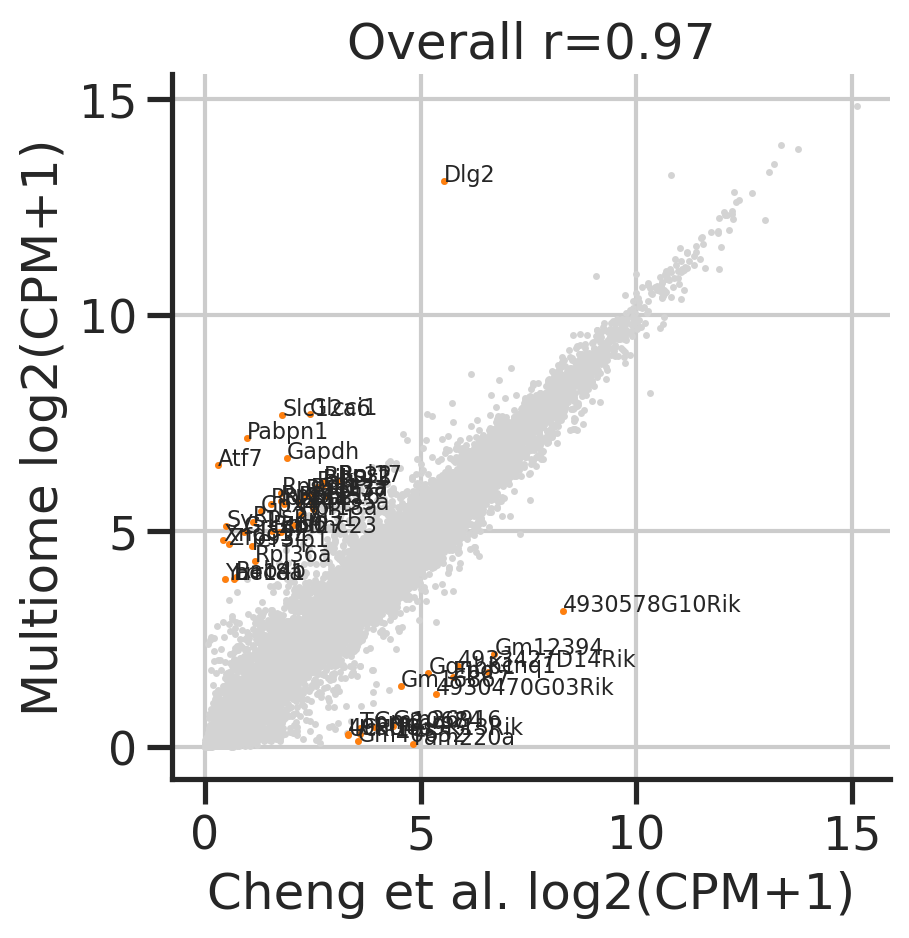

In [27]:

fig, ax = plt.subplots(1,1, figsize=(1*5, 1*5)) #, sharex=True, sharey=True)
x = np.mean(tensor_rna[:2,:], axis=(0,1))
y = np.mean(tensor_mul[:2,:], axis=(0,1))
r, p = stats.pearsonr(x, y)
ax.scatter(x, y, s=1, color='lightgray')
ax.set_title(f'Overall r={r:.2f}')

cond = np.abs(y-x) > 3 # FC of 2**3 
# cond = np.array([g in ['Xist','Malat1'] for g in genes_mul])
for xk, yk, gk in zip(x[cond], y[cond], genes_mul[cond]):
    ax.text(xk, yk, gk, fontsize=8)
ax.scatter(x[cond], y[cond], s=1, color='C1')

sns.despine(ax=ax)
ax.set_aspect('equal')
ax.set_xticks([0,5,10,15])
ax.set_yticks([0,5,10,15])

ax.set_xlabel('Cheng et al. log2(CPM+1)')
ax.set_ylabel('Multiome log2(CPM+1)')

fig.tight_layout()
plt.show()

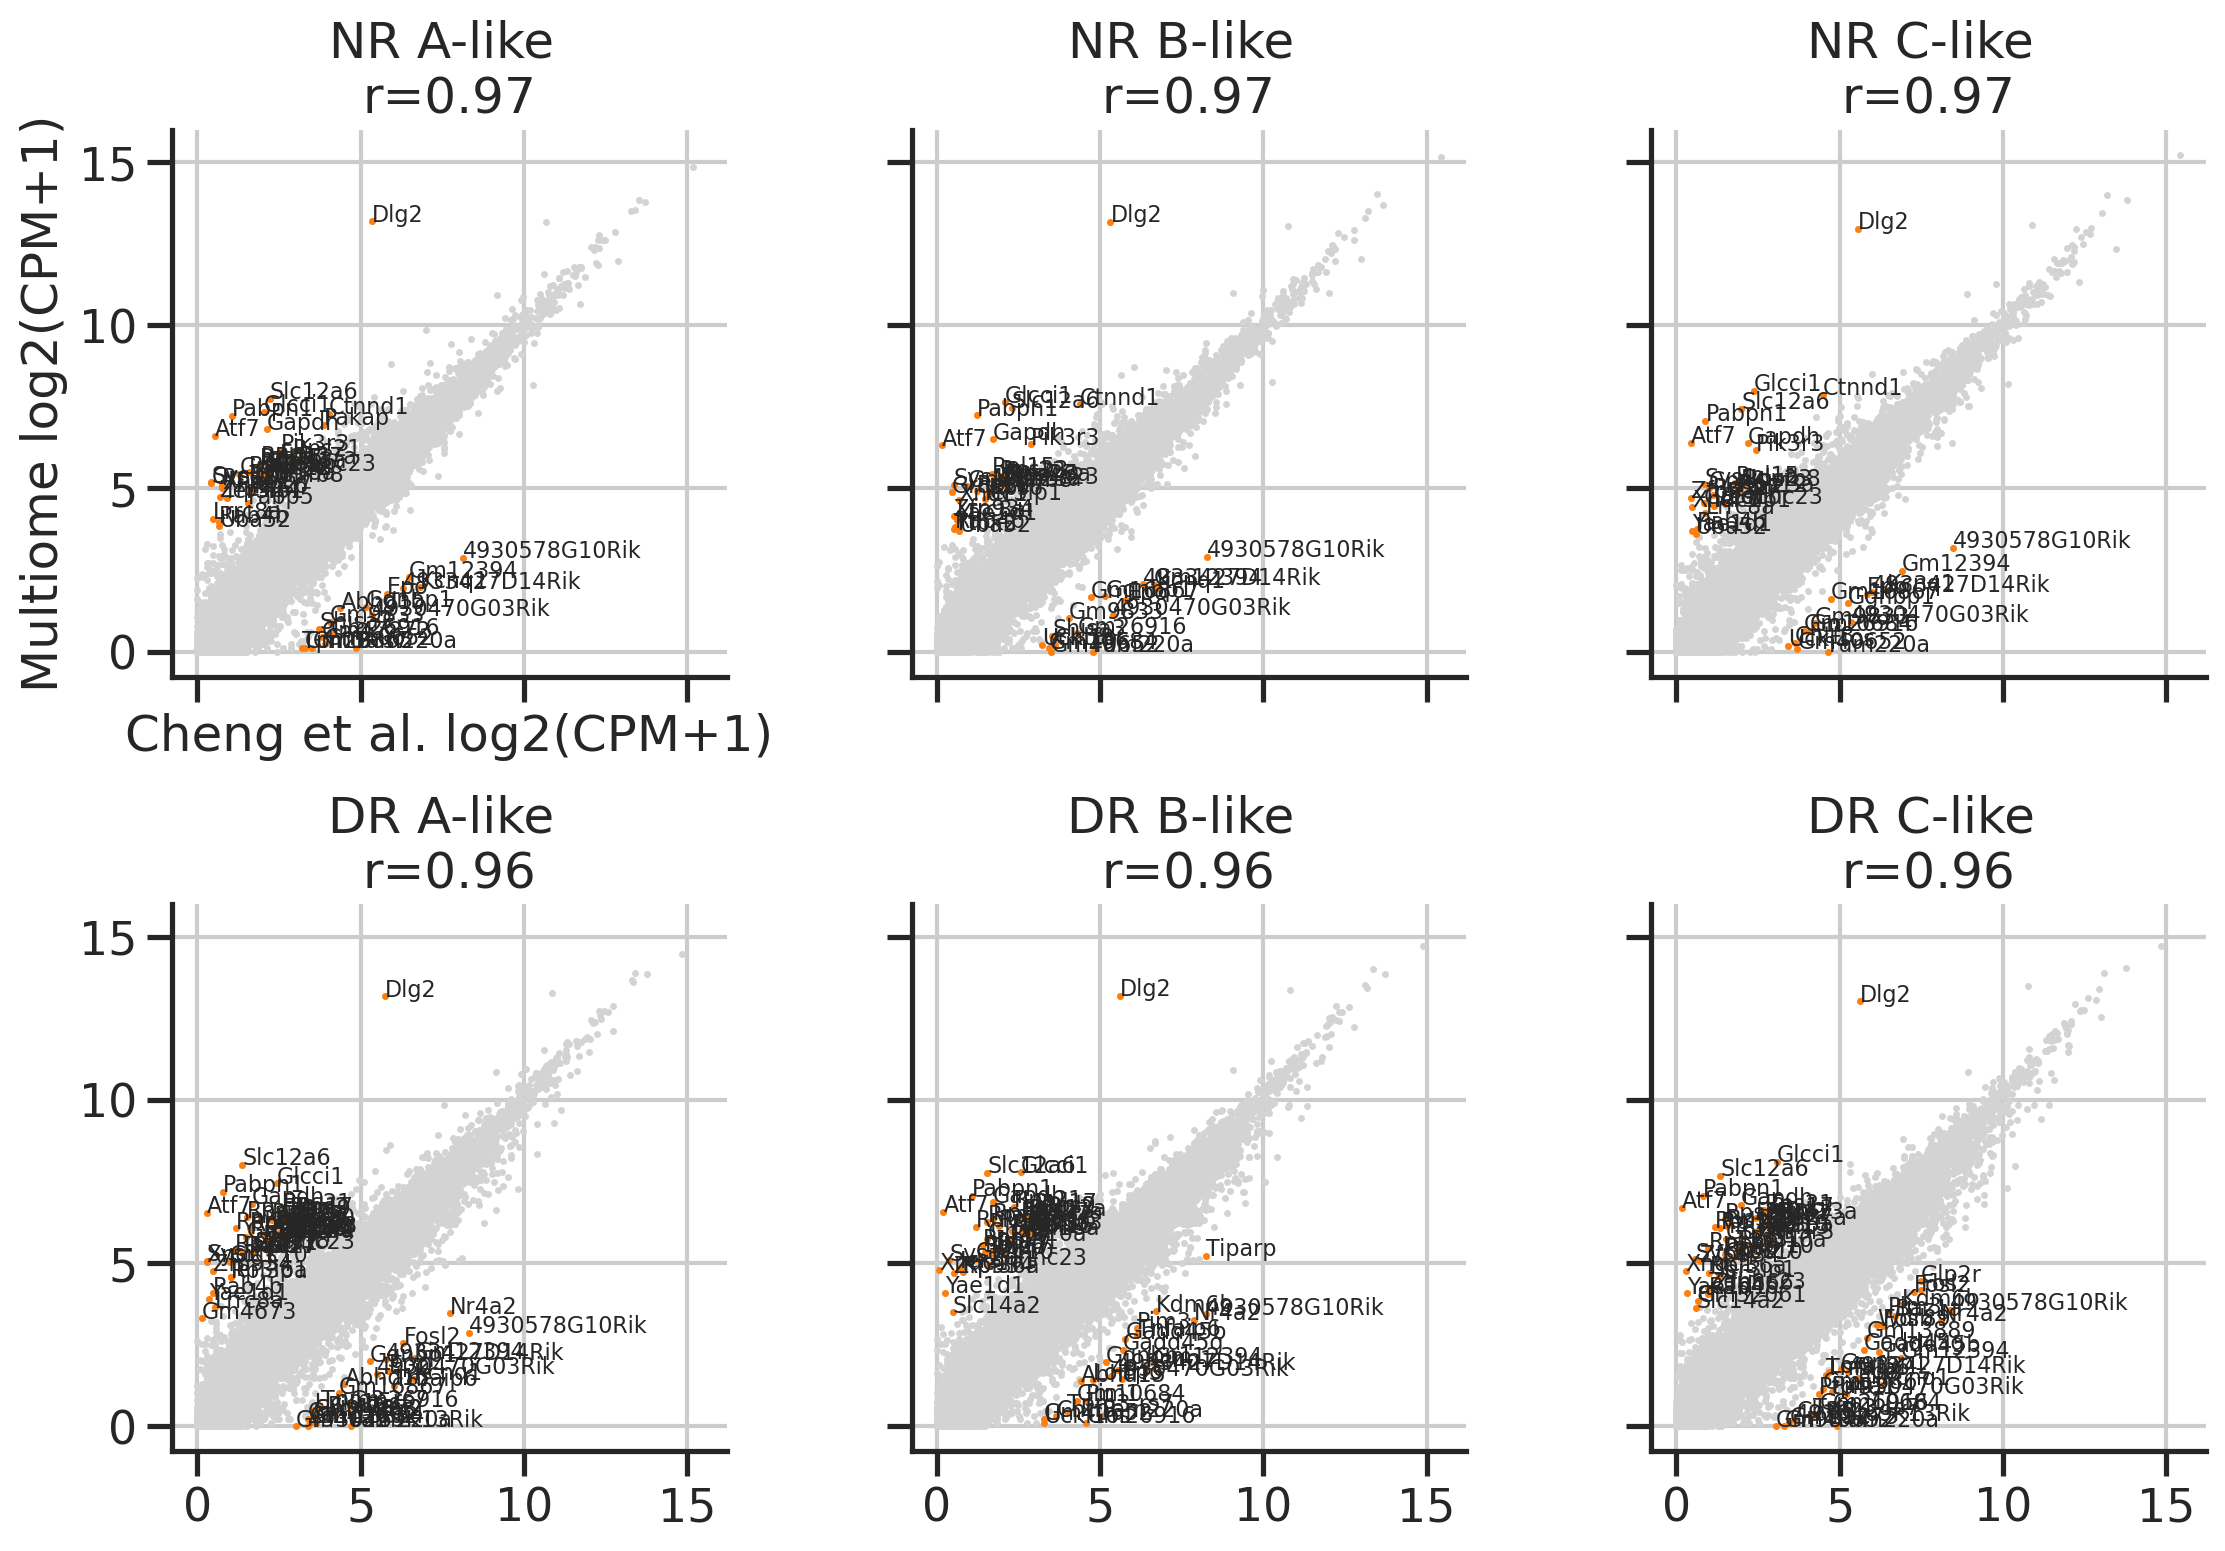

In [28]:
# consistency of overall gene expression

fig, axs = plt.subplots(2,3, figsize=(3*4, 2*4), sharex=True, sharey=True)
for i in range(2):
    label_i = ['NR', 'DR'][i]
    for j in range(3):
        label_j = ['A', 'B', 'C'][j]
        
        ax = axs[i,j]
        x, y = tensor_rna[i,j], tensor_mul[i,j]
        r, p = stats.pearsonr(x, y)
        ax.scatter(x, y, s=1, color='lightgray')
        ax.set_title(f'{label_i} {label_j}-like \nr={r:.2f}')
        
        cond = np.abs(y-x) > 3 # FC of 2**3 
        for xk, yk, gk in zip(x[cond], y[cond], genes_mul[cond]):
            ax.text(xk, yk, gk, fontsize=8)
        ax.scatter(x[cond], y[cond], s=1, color='C1')
            
        sns.despine(ax=ax)
        ax.set_aspect('equal')

axs[0,0].set_xlabel('Cheng et al. log2(CPM+1)')
axs[0,0].set_ylabel('Multiome log2(CPM+1)')

fig.tight_layout()
plt.show()

# consistency of type specificity (difference between types measured in FC)

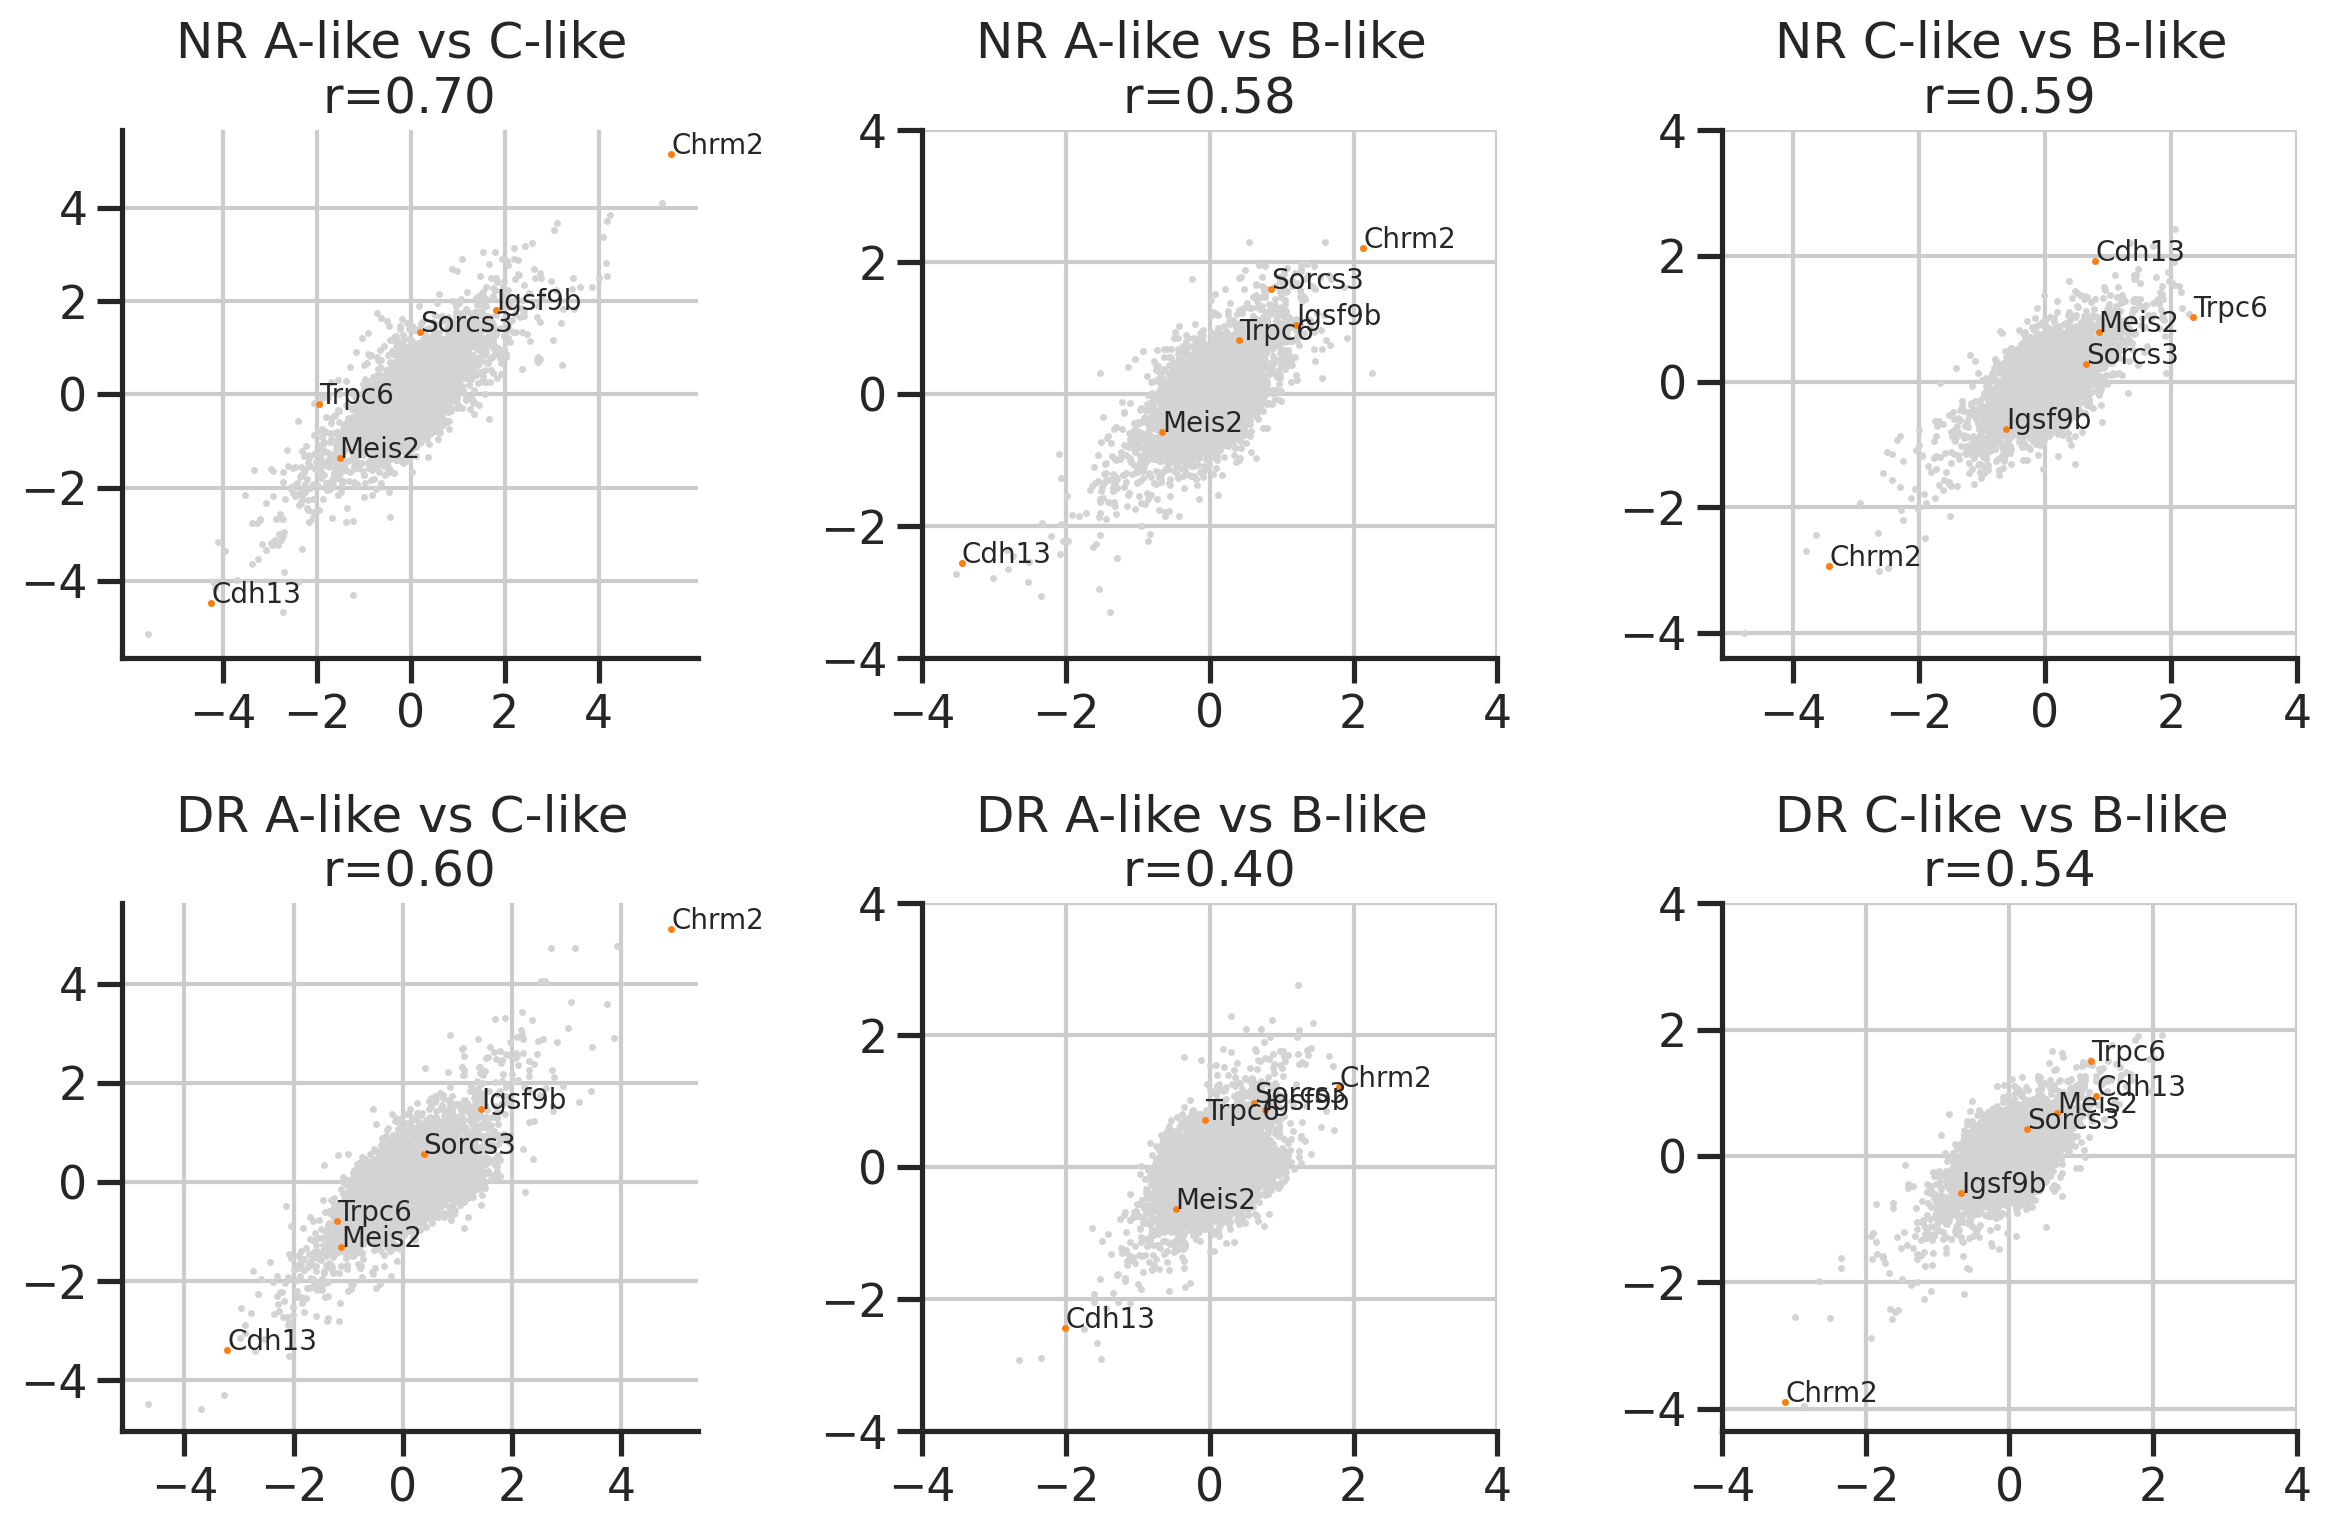

In [29]:

cond = basicu.get_index_from_array(genes_mul, ['Cdh13', 'Trpc6', 'Chrm2', 'Meis2', 'Sorcs3', 'Igsf9b', ])

fig, axs = plt.subplots(2,3, figsize=(3*4, 2*4)) # , sharex=True, sharey=True)
for i in range(2):
    label_i = ['NR', 'DR'][i]
    for j, j0, j1 in [(0, 0,2), (1, 0,1), (2, 2,1)]:
        
        ax = axs[i,j]
        label_j0 = ['A', 'B', 'C'][j0]
        label_j1 = ['A', 'B', 'C'][j1]
        
        x0 = tensor_rna[i,j0]
        x1 = tensor_rna[i,j1]
        
        y0 = tensor_mul[i,j0]
        y1 = tensor_mul[i,j1]
        
        x_fc = x1-x0
        y_fc = y1-y0
        
        r, p = stats.pearsonr(x_fc, y_fc)
        ax.set_title(f'{label_i} {label_j0}-like vs {label_j1}-like \nr={r:.2f}')
        
        ax.scatter(x_fc, y_fc, s=1, color='lightgray')
        ax.scatter(x_fc[cond], y_fc[cond], s=1, color='C1')
        for xk, yk, gk in zip(x_fc[cond], y_fc[cond], genes_mul[cond]):
            ax.text(xk, yk, gk, fontsize=10)
        ax.set_ylim(bottom=1.1*np.min(y_fc), top=1.1*np.max(y_fc))
        # ax.set_yticks(ax.get_xticks())
        # ax.set_xticks(ax.get_yticks())
        # print(ax.get_yticks())
        # print(ax.get_xticks())
        ax.set_yticks([-4,-2,0,2,4])
        ax.set_xticks([-4,-2,0,2,4])
        sns.despine(ax=ax)

# axs[0,0].set_xlabel('Cheng et al. log2(FC)')
# axs[0,0].set_ylabel('Multiome log2(FC)')
fig.tight_layout()


# consistency of vision (difference between NR and DR)

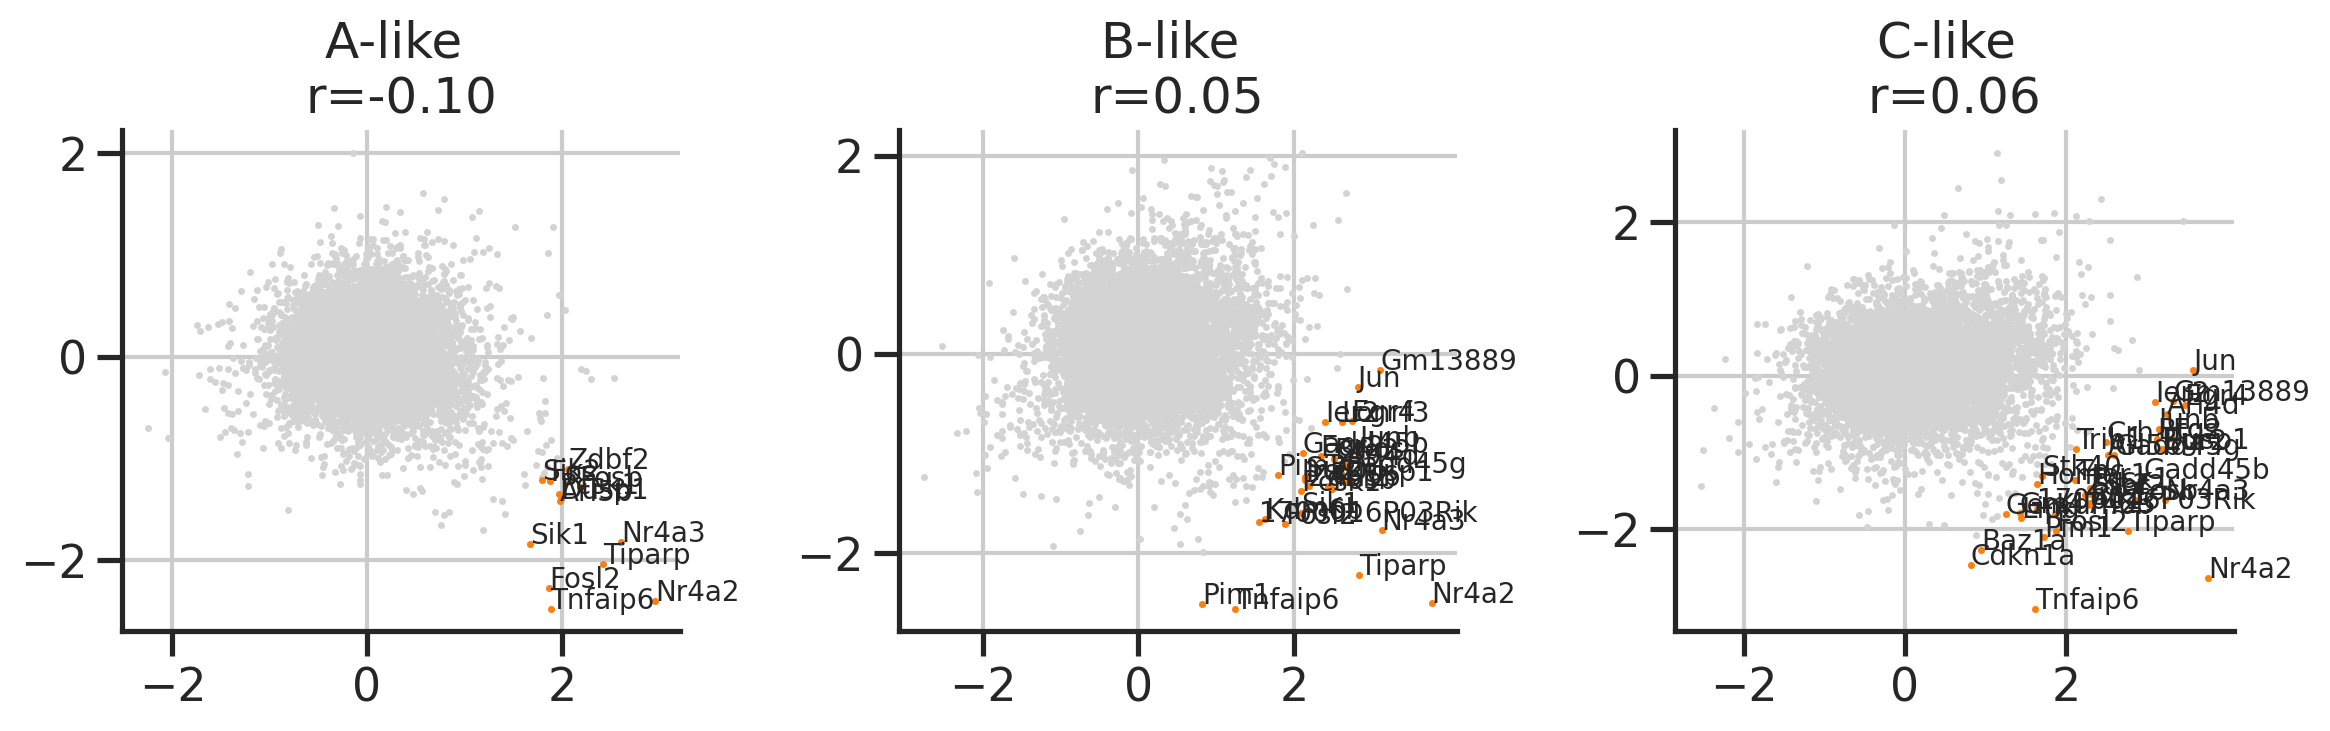

In [30]:
fig, axs = plt.subplots(1,3, figsize=(3*4, 4)) # , sharex=True, sharey=True)
for j in range(3): # (0, 0,2), (1, 0,1), (2, 2,1)]:
    ax = axs[j]
    label_j = ['A', 'B', 'C'][j]

    x0 = tensor_rna[0,j]
    x1 = tensor_rna[1,j]

    y0 = tensor_mul[0,j]
    y1 = tensor_mul[1,j]

    x_fc = x1-x0
    y_fc = y1-y0

    r, p = stats.pearsonr(x_fc, y_fc)
    ax.set_title(f'{label_j}-like \nr={r:.2f}')

    ax.scatter(x_fc, y_fc, s=1, color='lightgray')

    cond = np.abs(y_fc - x_fc) > 3
    for xk, yk, gk in zip(x_fc[cond], y_fc[cond], genes_mul[cond]):
        ax.text(xk, yk, gk, fontsize=10)
    ax.scatter(x_fc[cond], y_fc[cond], s=1, color='C1')

    sns.despine(ax=ax)
    ax.set_xticks([-2,0,2])
    ax.set_yticks([-2,0,2])

# axs[0].set_xlabel('Cheng et al. log2(DR/NR)')
# axs[0].set_ylabel('Multiome log2(DR/NR)')
fig.tight_layout()

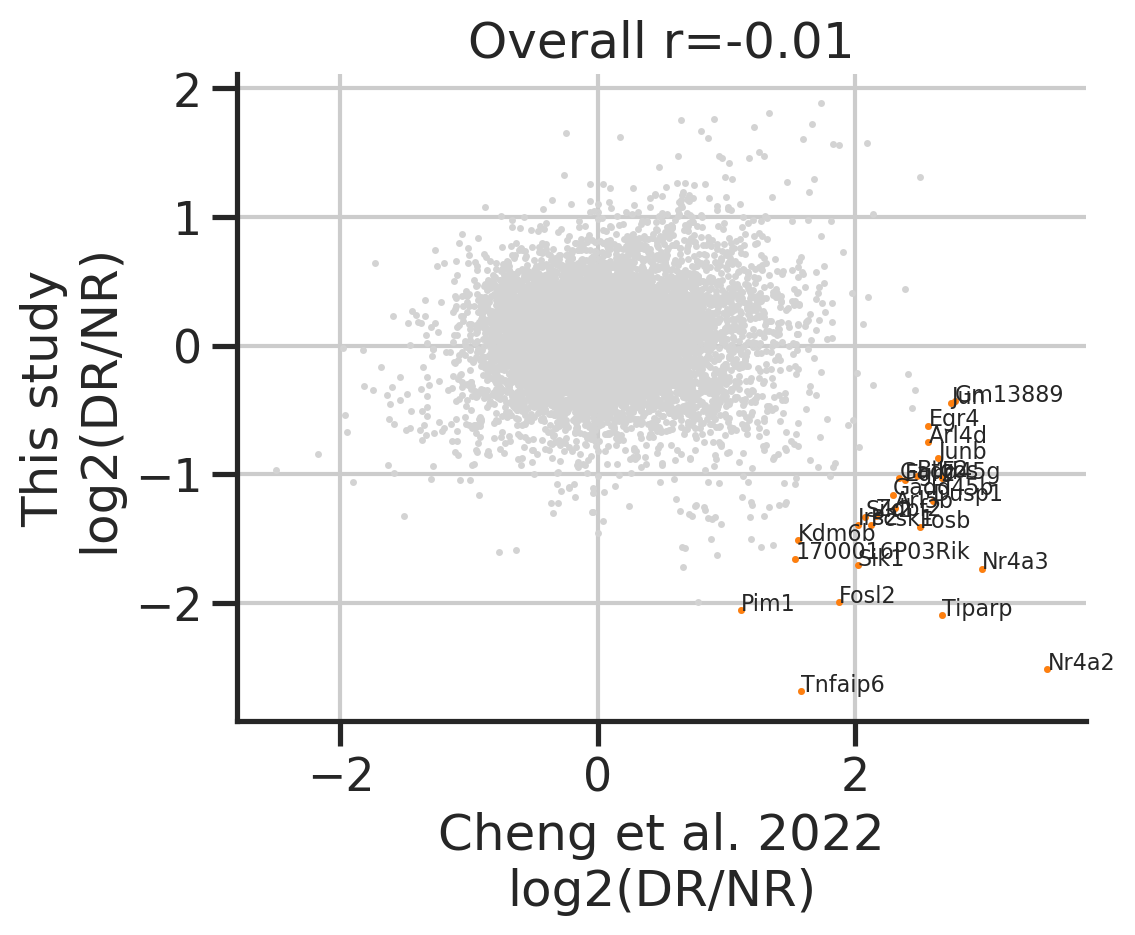

In [31]:
fig, ax = plt.subplots(1,1, figsize=(1*6, 1*6)) #, sharex=True, sharey=True)
x = np.mean(tensor_rna[1]-tensor_rna[0], axis=(0))
y = np.mean(tensor_mul[1]-tensor_mul[0], axis=(0))



r, p = stats.pearsonr(x, y)
ax.scatter(x, y, s=1, color='lightgray')
ax.set_title(f'Overall r={r:.2f}')

cond = np.abs(y-x) > 3 # FC of 2**3 
# cond = np.array([g in ['Xist','Malat1'] for g in genes_mul])
for xk, yk, gk in zip(x[cond], y[cond], genes_mul[cond]):
    ax.text(xk, yk, gk, fontsize=8)
ax.scatter(x[cond], y[cond], s=1, color='C1')

sns.despine(ax=ax)
ax.set_aspect('equal')
# ax.set_xticks([0,5,10,15])
# ax.set_yticks([0,5,10,15])

ax.set_xlabel('Cheng et al. 2022\nlog2(DR/NR)')
ax.set_ylabel('This study\nlog2(DR/NR)')

fig.tight_layout()
plt.show()

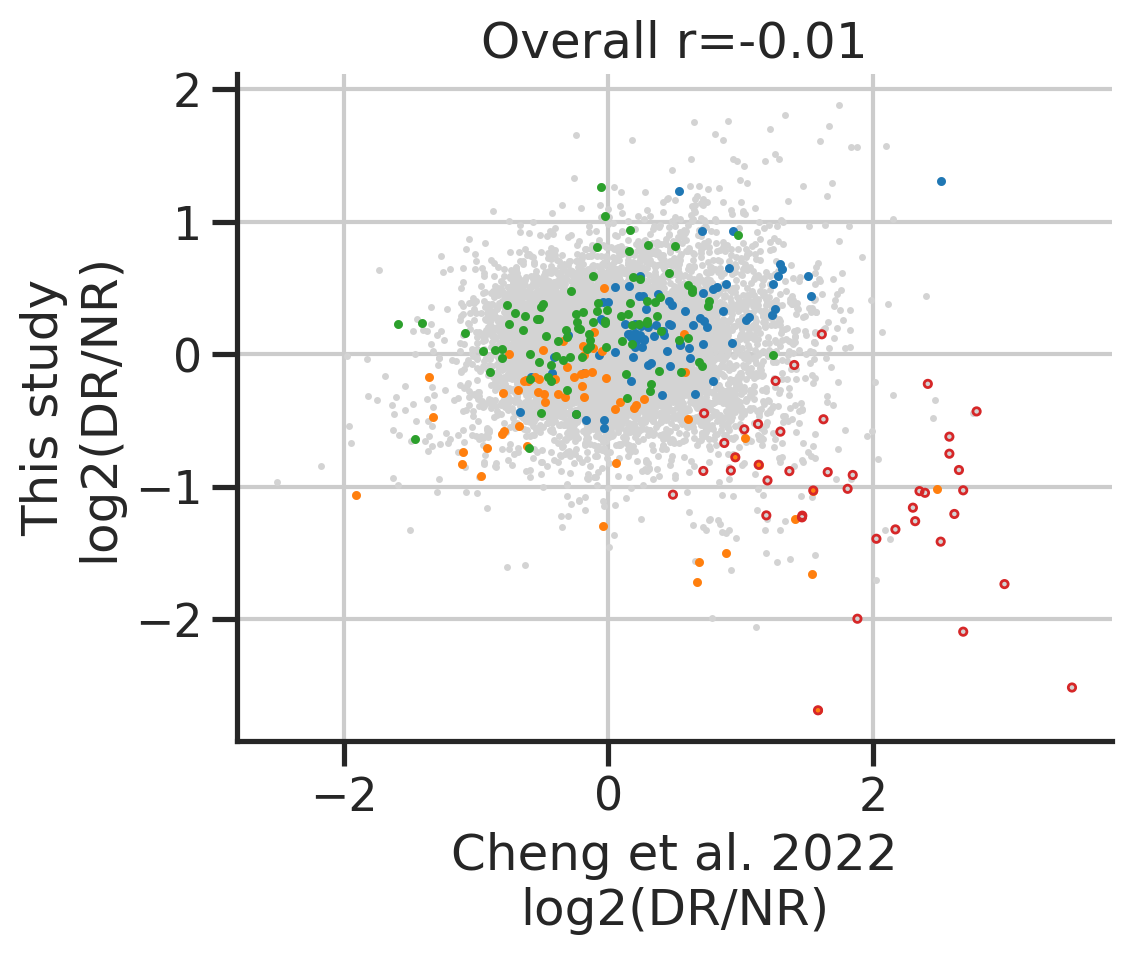

In [34]:
cond_a = basicu.get_index_from_array(genes_mul, agenes)
cond_b = basicu.get_index_from_array(genes_mul, bgenes)
cond_c = basicu.get_index_from_array(genes_mul, cgenes)
cond_i = basicu.get_index_from_array(genes_mul, iegs) 

fig, ax = plt.subplots(1,1, figsize=(1*6, 1*6)) #, sharex=True, sharey=True)
x = np.mean(tensor_rna[1]-tensor_rna[0], axis=(0))
y = np.mean(tensor_mul[1]-tensor_mul[0], axis=(0))


r, p = stats.pearsonr(x, y)
ax.scatter(x, y, s=1, color='lightgray')
ax.set_title(f'Overall r={r:.2f}')

# cond = np.abs(y-x) > 3 # FC of 2**3 
# # cond = np.array([g in ['Xist','Malat1'] for g in genes_mul])
# for xk, yk, gk in zip(x[cond], y[cond], genes_mul[cond]):
#     ax.text(xk, yk, gk, fontsize=8)
# ax.scatter(x[cond], y[cond], s=1, color='C1')

sns.despine(ax=ax)
ax.set_aspect('equal')
# ax.set_xticks([0,5,10,15])
# ax.set_yticks([0,5,10,15])

ax.scatter(x[cond_a], y[cond_a], s=3, color='C0')
ax.scatter(x[cond_b], y[cond_b], s=3, color='C1')
ax.scatter(x[cond_c], y[cond_c], s=3, color='C2')
ax.scatter(x[cond_i], y[cond_i], s=7, color='C3', facecolor='none', linewidths=1)

ax.set_xlabel('Cheng et al. 2022\nlog2(DR/NR)')
ax.set_ylabel('This study\nlog2(DR/NR)')

fig.tight_layout()
plt.show()

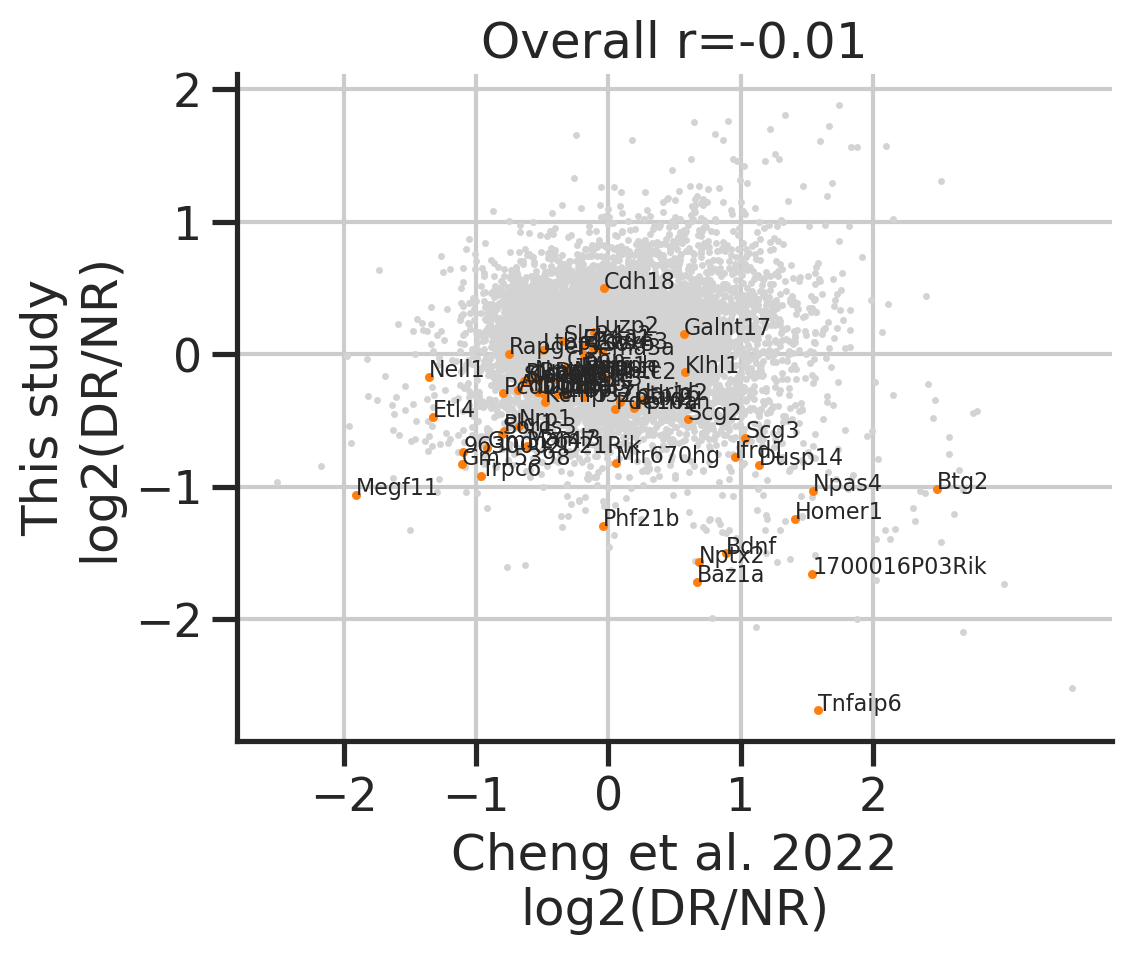

In [40]:

cond_a = basicu.get_index_from_array(genes_mul, agenes)
cond_b = basicu.get_index_from_array(genes_mul, bgenes)
cond_c = basicu.get_index_from_array(genes_mul, cgenes)
cond_i = basicu.get_index_from_array(genes_mul, iegs) 

fig, ax = plt.subplots(1,1, figsize=(1*6, 1*6)) #, sharex=True, sharey=True)
x = np.mean(tensor_rna[1]-tensor_rna[0], axis=(0))
y = np.mean(tensor_mul[1]-tensor_mul[0], axis=(0))


r, p = stats.pearsonr(x, y)
ax.scatter(x, y, s=1, color='lightgray')
ax.set_title(f'Overall r={r:.2f}')

ax.scatter(x[cond_b], y[cond_b], s=3, color='C1')
cond = cond_b # np.abs(y-x) > 3 # FC of 2**3 
for xk, yk, gk in zip(x[cond], y[cond], genes_mul[cond]):
    ax.text(xk, yk, gk, fontsize=8)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([-2, -1, 0, 1, 2])

sns.despine(ax=ax)
ax.set_aspect('equal')


ax.set_xlabel('Cheng et al. 2022\nlog2(DR/NR)')
ax.set_ylabel('This study\nlog2(DR/NR)')

fig.tight_layout()
plt.show()

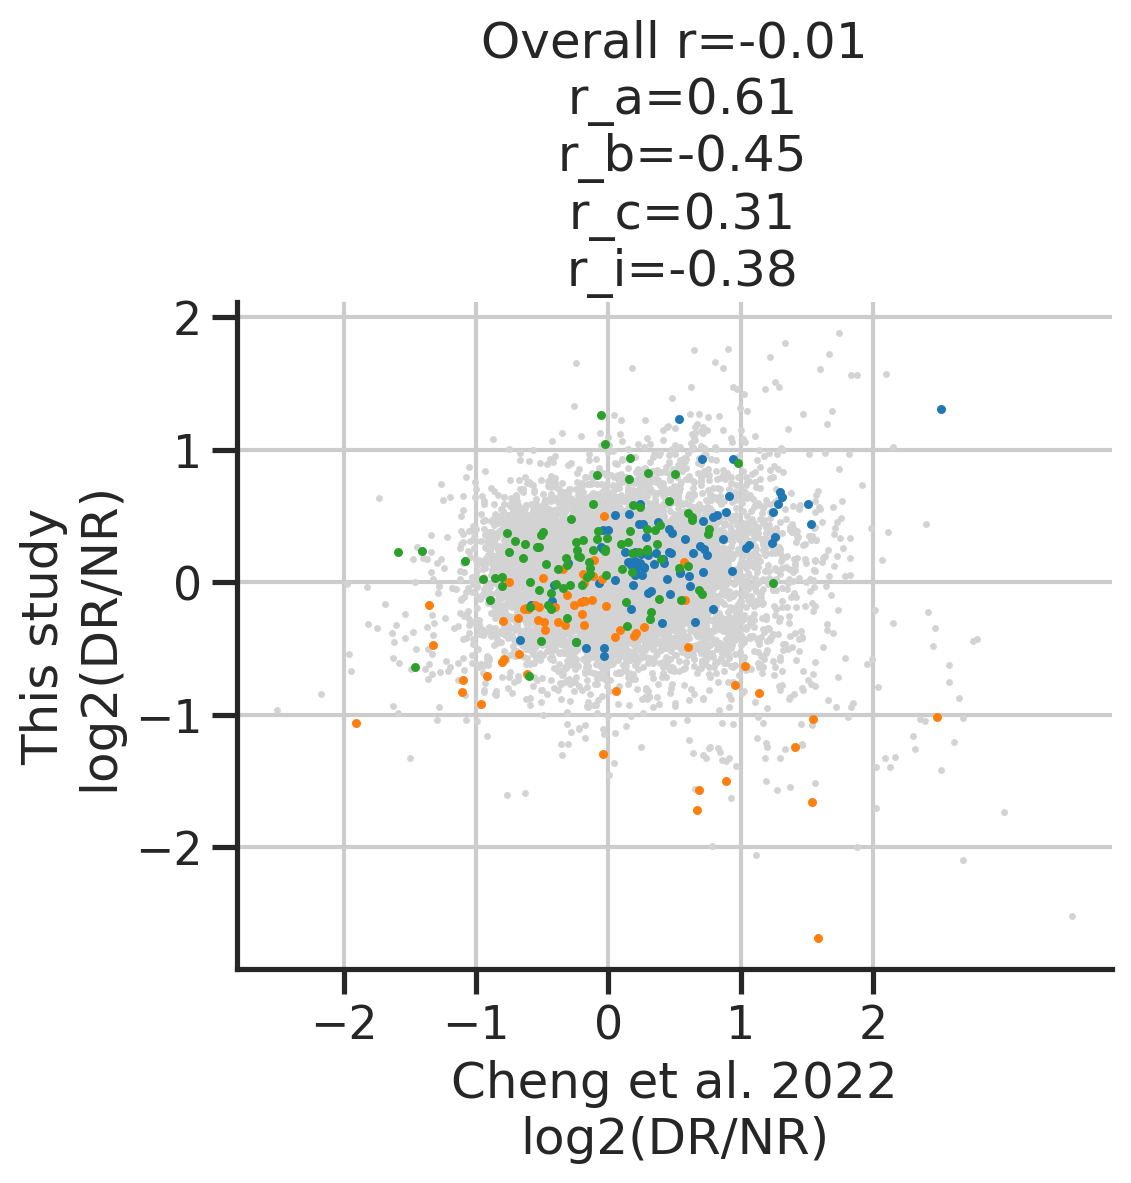

In [53]:

cond_a = basicu.get_index_from_array(genes_mul, agenes)
cond_b = basicu.get_index_from_array(genes_mul, bgenes)
cond_c = basicu.get_index_from_array(genes_mul, cgenes)
cond_i = basicu.get_index_from_array(genes_mul, iegs) 

fig, ax = plt.subplots(1,1, figsize=(1*6, 1*6)) #, sharex=True, sharey=True)
x = np.mean(tensor_rna[1]-tensor_rna[0], axis=(0))
y = np.mean(tensor_mul[1]-tensor_mul[0], axis=(0))


ax.scatter(x, y, s=1, color='lightgray')


ax.scatter(x[cond_a], y[cond_a], s=3, color='C0')
ax.scatter(x[cond_b], y[cond_b], s=3, color='C1')
ax.scatter(x[cond_c], y[cond_c], s=3, color='C2')
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([-2, -1, 0, 1, 2])

r, p = stats.pearsonr(x, y)
r_a, p = stats.pearsonr(x[cond_a], y[cond_a])
r_b, p = stats.pearsonr(x[cond_b], y[cond_b])
r_c, p = stats.pearsonr(x[cond_c], y[cond_c])
r_i, p = stats.pearsonr(x[cond_i], y[cond_i])
ax.set_title(f'Overall r={r:.2f}\n r_a={r_a:.2f}\n r_b={r_b:.2f}\n r_c={r_c:.2f}\n r_i={r_i:.2f}', )

sns.despine(ax=ax)
ax.set_aspect('equal')


ax.set_xlabel('Cheng et al. 2022\nlog2(DR/NR)')
ax.set_ylabel('This study\nlog2(DR/NR)')

fig.tight_layout()
plt.show()

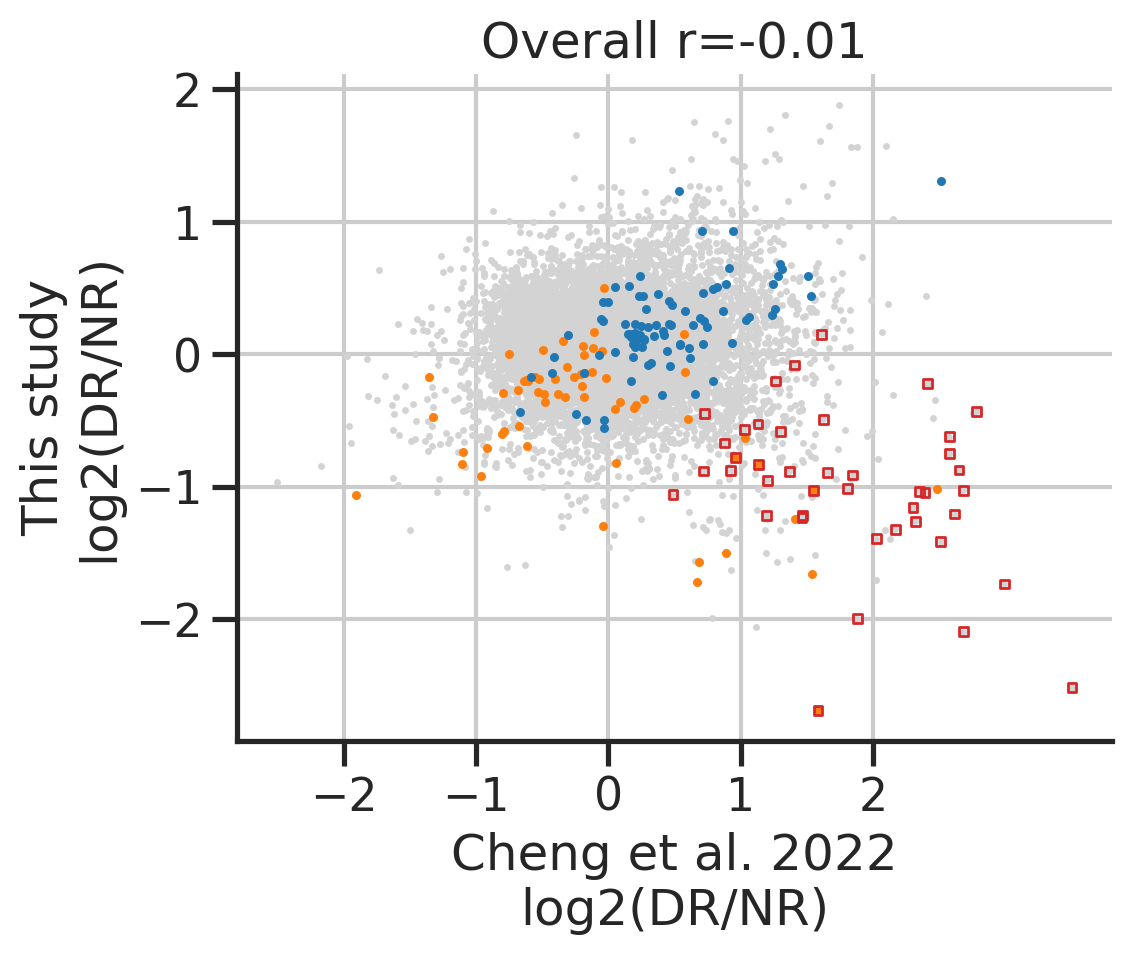

In [51]:

cond_a = basicu.get_index_from_array(genes_mul, agenes)
cond_b = basicu.get_index_from_array(genes_mul, bgenes)
cond_c = basicu.get_index_from_array(genes_mul, cgenes)

fig, ax = plt.subplots(1,1, figsize=(1*6, 1*6)) #, sharex=True, sharey=True)
x = np.mean(tensor_rna[1]-tensor_rna[0], axis=(0))
y = np.mean(tensor_mul[1]-tensor_mul[0], axis=(0))


r, p = stats.pearsonr(x, y)
ax.scatter(x, y, s=1, color='lightgray')
ax.set_title(f'Overall r={r:.2f}')

ax.scatter(x[cond_b], y[cond_b], s=3, color='C1')
# ax.scatter(x[cond_c], y[cond_c], s=3, color='C2')
ax.scatter(x[cond_a], y[cond_a], s=3, color='C0')
ax.scatter(x[cond_i], y[cond_i], s=10, color='C3', facecolor='none', linewidths=1, marker='s')
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([-2, -1, 0, 1, 2])

sns.despine(ax=ax)
ax.set_aspect('equal')


ax.set_xlabel('Cheng et al. 2022\nlog2(DR/NR)')
ax.set_ylabel('This study\nlog2(DR/NR)')

fig.tight_layout()
plt.show()

In [21]:
f = '/u/home/f/f7xiesnm/v1_multiome/juyoun/regulons_l23alltime_trimmed_cleaned_bigtable.csv'
# scenic metadata
df_scenic = pd.read_csv(f, index_col=0)
df_scenic = df_scenic[df_scenic['signs'].isin(["+_+", "-_+"])]

In [27]:
all_regulons = df_scenic['Consensus_name'].unique()

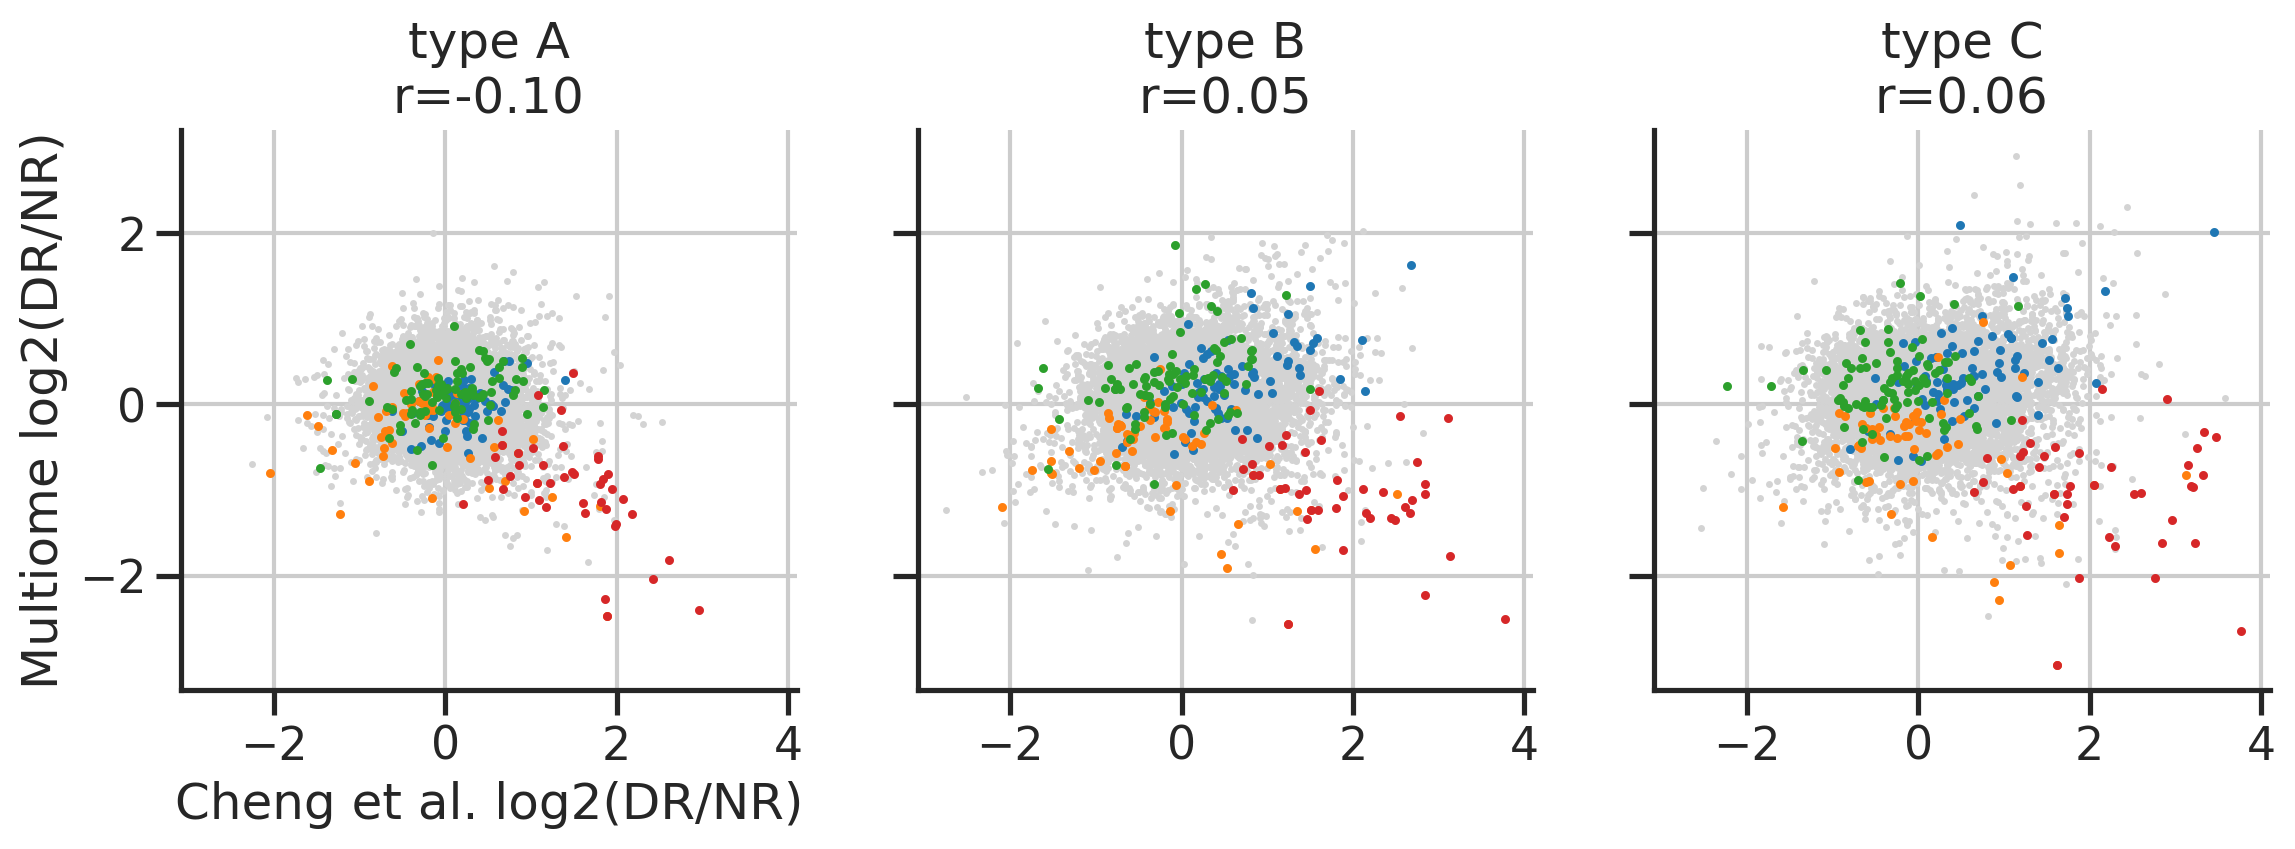

In [33]:
cond_a = basicu.get_index_from_array(genes_mul, agenes)
cond_b = basicu.get_index_from_array(genes_mul, bgenes)
cond_c = basicu.get_index_from_array(genes_mul, cgenes)
cond_i = basicu.get_index_from_array(genes_mul, iegs) 


fig, axs = plt.subplots(1,3, figsize=(3*4, 4), sharex=True, sharey=True)
for j in range(3): # (0, 0,2), (1, 0,1), (2, 2,1)]:
    ax = axs[j]
    label_j = ['A', 'B', 'C'][j]

    x0 = tensor_rna[0,j]
    x1 = tensor_rna[1,j]

    y0 = tensor_mul[0,j]
    y1 = tensor_mul[1,j]

    x_fc = x1-x0
    y_fc = y1-y0

    cond = np.abs(y_fc - x_fc) > 5
    
    r, p = stats.pearsonr(x_fc, y_fc)
    ax.set_title(f'type {label_j}\nr={r:.2f}')

    ax.scatter(x_fc[~cond] , y_fc[~cond] , s=1, color='lightgray')
    ax.scatter(x_fc[cond_a], y_fc[cond_a], s=3, color='C0')
    ax.scatter(x_fc[cond_b], y_fc[cond_b], s=3, color='C1')
    ax.scatter(x_fc[cond_c], y_fc[cond_c], s=3, color='C2')
    ax.scatter(x_fc[cond_i], y_fc[cond_i], s=3, color='C3')


    sns.despine(ax=ax)
    ax.set_aspect('equal')

axs[0].set_xlabel('Cheng et al. log2(DR/NR)')
axs[0].set_ylabel('Multiome log2(DR/NR)')
fig.tight_layout()

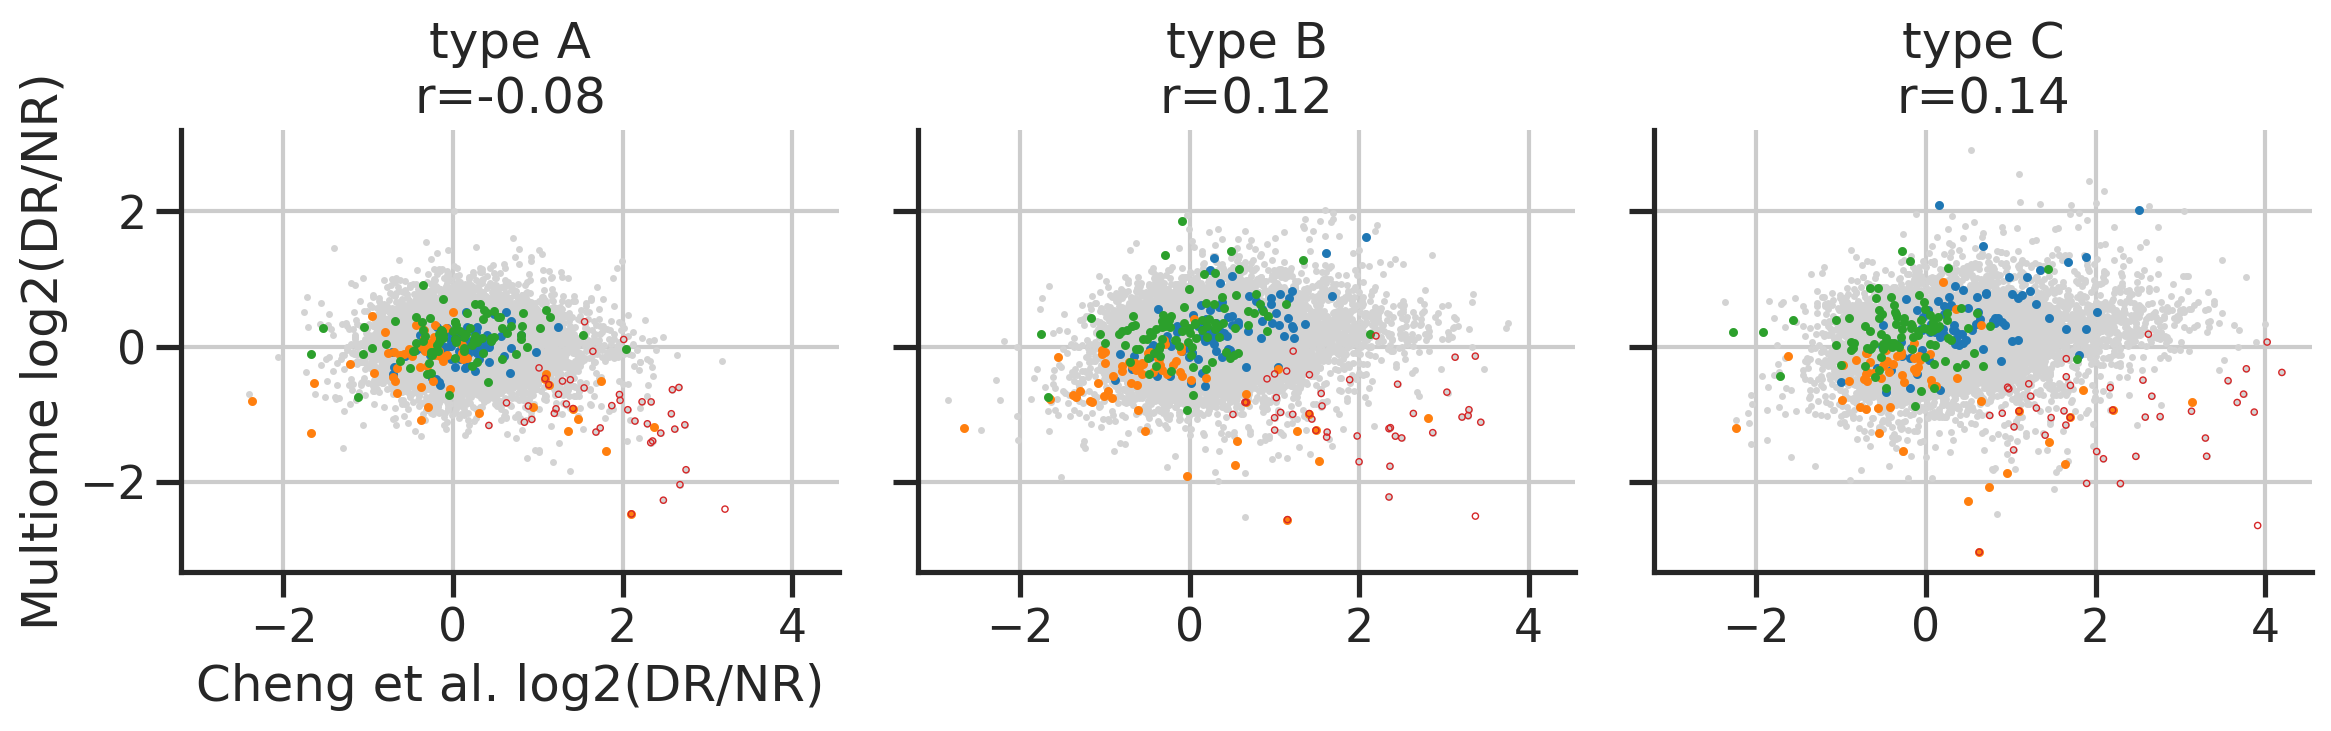

In [34]:
cond_a = basicu.get_index_from_array(genes_mul, agenes)
cond_b = basicu.get_index_from_array(genes_mul, bgenes)
cond_c = basicu.get_index_from_array(genes_mul, cgenes)
cond_i = basicu.get_index_from_array(genes_mul, iegs) 


fig, axs = plt.subplots(1,3, figsize=(3*4, 4), sharex=True, sharey=True)
for j in range(3): # (0, 0,2), (1, 0,1), (2, 2,1)]:
    ax = axs[j]
    label_j = ['A', 'B', 'C'][j]

    x0 = tensor_rna[2,j]
    x1 = tensor_rna[1,j]

    y0 = tensor_mul[0,j]
    y1 = tensor_mul[1,j]

    x_fc = x1-x0 # (use the same basis)!
    y_fc = y1-y0

    cond = np.abs(y_fc - x_fc) > 5
    
    r, p = stats.pearsonr(x_fc, y_fc)
    ax.set_title(f'type {label_j}\nr={r:.2f}')

    ax.scatter(x_fc[~cond] , y_fc[~cond] , s=1, color='lightgray')
    ax.scatter(x_fc[cond_a], y_fc[cond_a], s=3, color='C0')
    ax.scatter(x_fc[cond_b], y_fc[cond_b], s=3, color='C1')
    ax.scatter(x_fc[cond_c], y_fc[cond_c], s=3, color='C2')
    ax.scatter(x_fc[cond_i], y_fc[cond_i], s=5, color='C3', facecolor='none', linewidths=0.5)


    sns.despine(ax=ax)
    # ax.set_aspect('equal')

axs[0].set_xlabel('Cheng et al. log2(DR/NR)')
axs[0].set_ylabel('Multiome log2(DR/NR)')
fig.tight_layout()

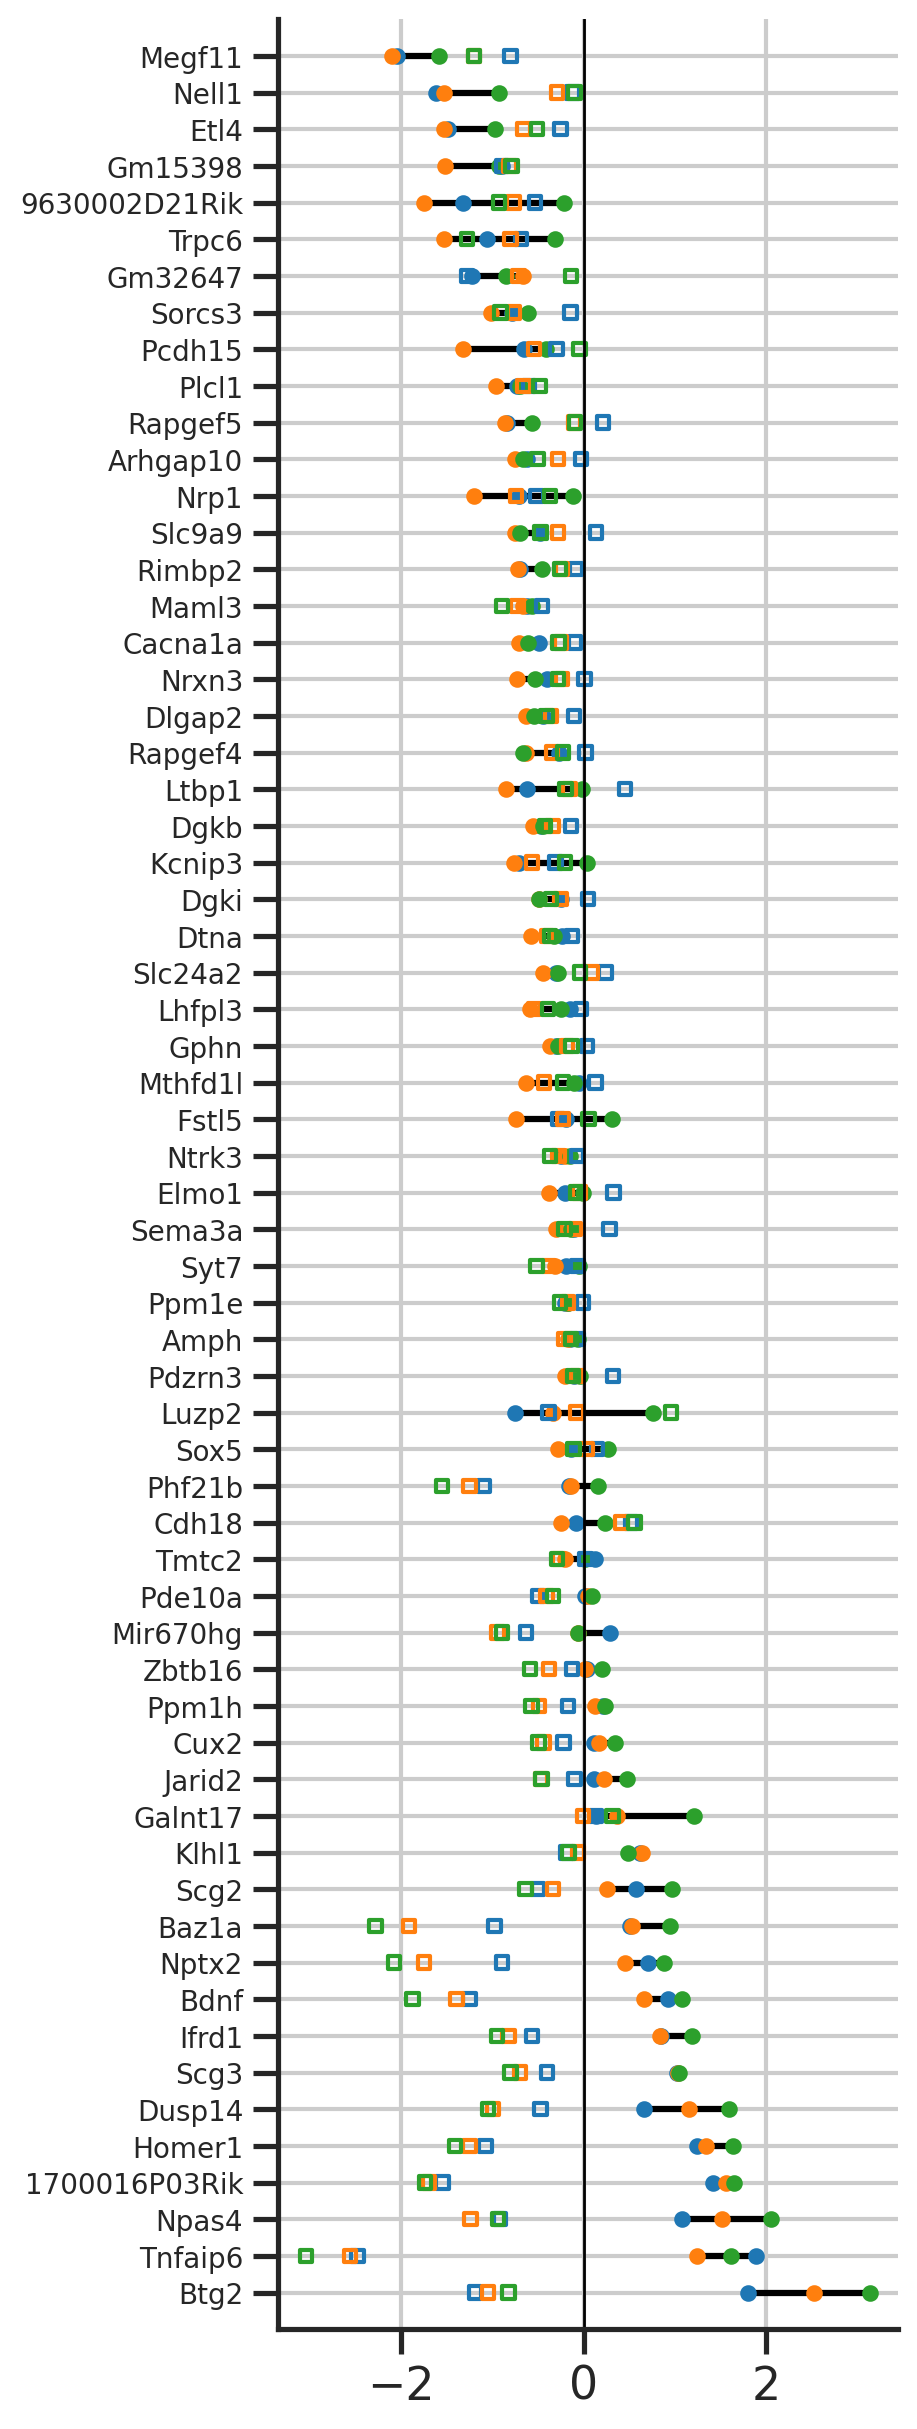

In [35]:
# combine all of them and show the changes are more in B an C
n_sub = len(cond_b)
genes_plot = genes_mul[cond_b]
del_sub = (tensor_rna[1]-tensor_rna[0])[:,cond_b]
del_sub_mean = np.mean(del_sub, axis=0)

del_sub2 = (tensor_mul[1]-tensor_mul[0])[:,cond_b]
del_sub2_mean = np.mean(del_sub2, axis=0)

support = np.arange(n_sub)
fig, ax = plt.subplots(1,1,figsize=(1*4,1*15), sharey=True)
idx = np.argsort(del_sub_mean)[::-1]

for i, isort in enumerate(idx):
    vals = del_sub[:,isort]
    val_min = vals[np.argmin(vals)]
    val_max = vals[np.argmax(vals)]
    ax.plot([val_min,val_max], [i,i], '-k', zorder=1)

ax.scatter(del_sub[0,idx], support, color='C0', s=20) #facecolor='none') 
ax.scatter(del_sub[1,idx], support, color='C1', s=20) #facecolor='none') 
ax.scatter(del_sub[2,idx], support, color='C2', s=20) #facecolor='none') 

ax.scatter(del_sub2[0,idx], support, color='C0', s=20, marker='s', facecolor='none') 
ax.scatter(del_sub2[1,idx], support, color='C1', s=20, marker='s', facecolor='none') 
ax.scatter(del_sub2[2,idx], support, color='C2', s=20, marker='s', facecolor='none') 
    
ax.set_yticks(support)
ax.set_yticklabels(genes_plot[idx], rotation=0, fontsize=10)
ax.set_ylim([-1, n_sub])
# # ax.set_xlim([-1,1])
ax.axvline(0, color='k', linestyle='-', zorder=1, linewidth=1)
sns.despine(ax=ax)
# ax.set_ylabel(f'Archetype-enriched CSMs (n={n_subbc_csm})')
plt.show()

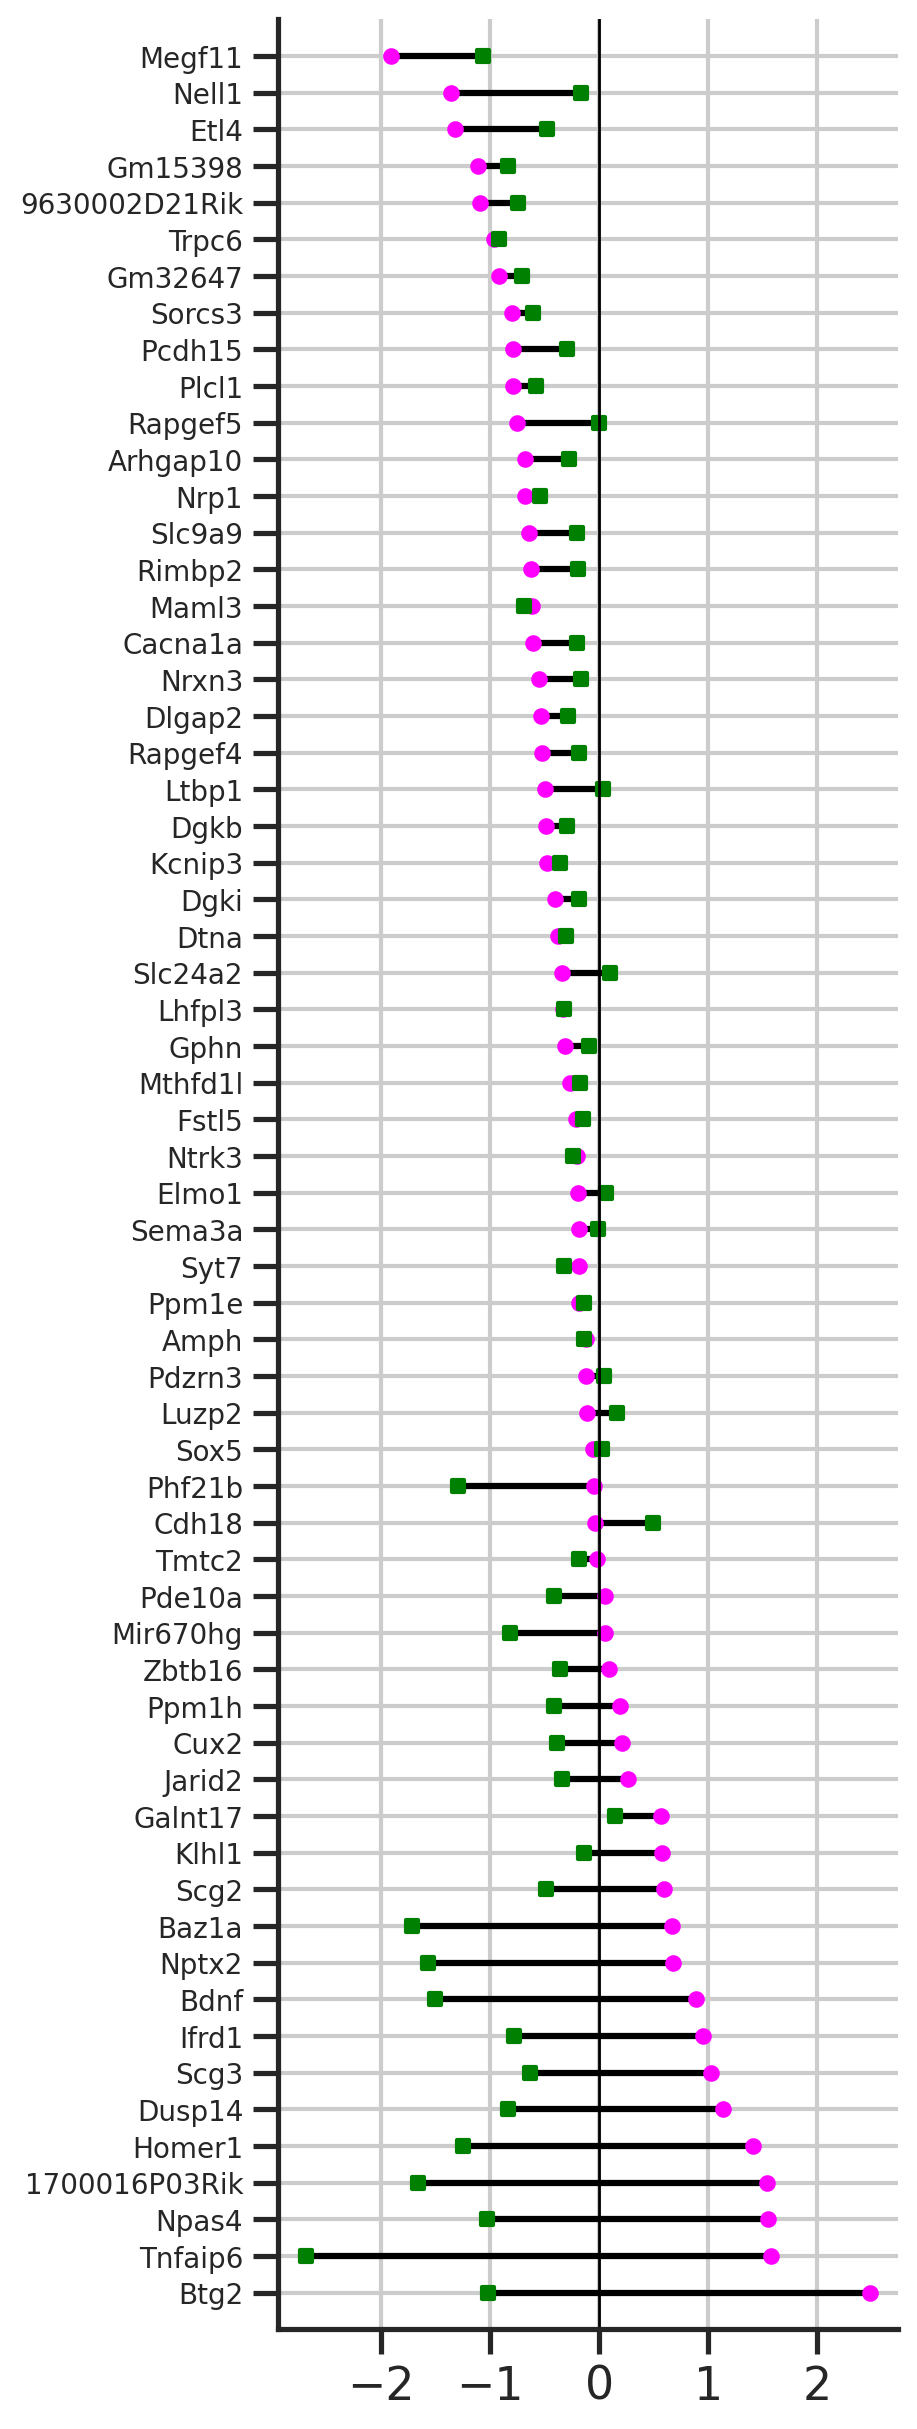

In [36]:
# combine all of them and show the changes are more in B an C
n_sub = len(cond_b)
genes_plot = genes_mul[cond_b]
del_sub = (tensor_rna[1]-tensor_rna[0])[:,cond_b]
del_sub2 = (tensor_mul[1]-tensor_mul[0])[:,cond_b]

del_sub_mean = np.mean(del_sub, axis=0)
del_sub2_mean = np.mean(del_sub2, axis=0)

support = np.arange(n_sub)
fig, ax = plt.subplots(1,1,figsize=(1*4,1*15), sharey=True)
idx = np.argsort(del_sub_mean)[::-1]

for i, isort in enumerate(idx):
    vals = np.array([del_sub_mean[isort], del_sub2_mean[isort]])
    val_min = vals[np.argmin(vals)]
    val_max = vals[np.argmax(vals)]
    ax.plot([val_min,val_max], [i,i], '-k', zorder=1)

ax.scatter(del_sub_mean[idx], support, color='magenta', s=20, )#facecolor='none') 
ax.scatter(del_sub2_mean[idx], support, color='green', s=20, marker='s', )# facecolor='none') 
    
ax.set_yticks(support)
ax.set_yticklabels(genes_plot[idx], rotation=0, fontsize=10)
ax.set_ylim([-1, n_sub])
# # ax.set_xlim([-1,1])
ax.set_xticks([-2,-1,0,1,2])
ax.axvline(0, color='k', linestyle='-', zorder=1, linewidth=1)
sns.despine(ax=ax)
# ax.set_ylabel(f'Archetype-enriched CSMs (n={n_subbc_csm})')
plt.show()

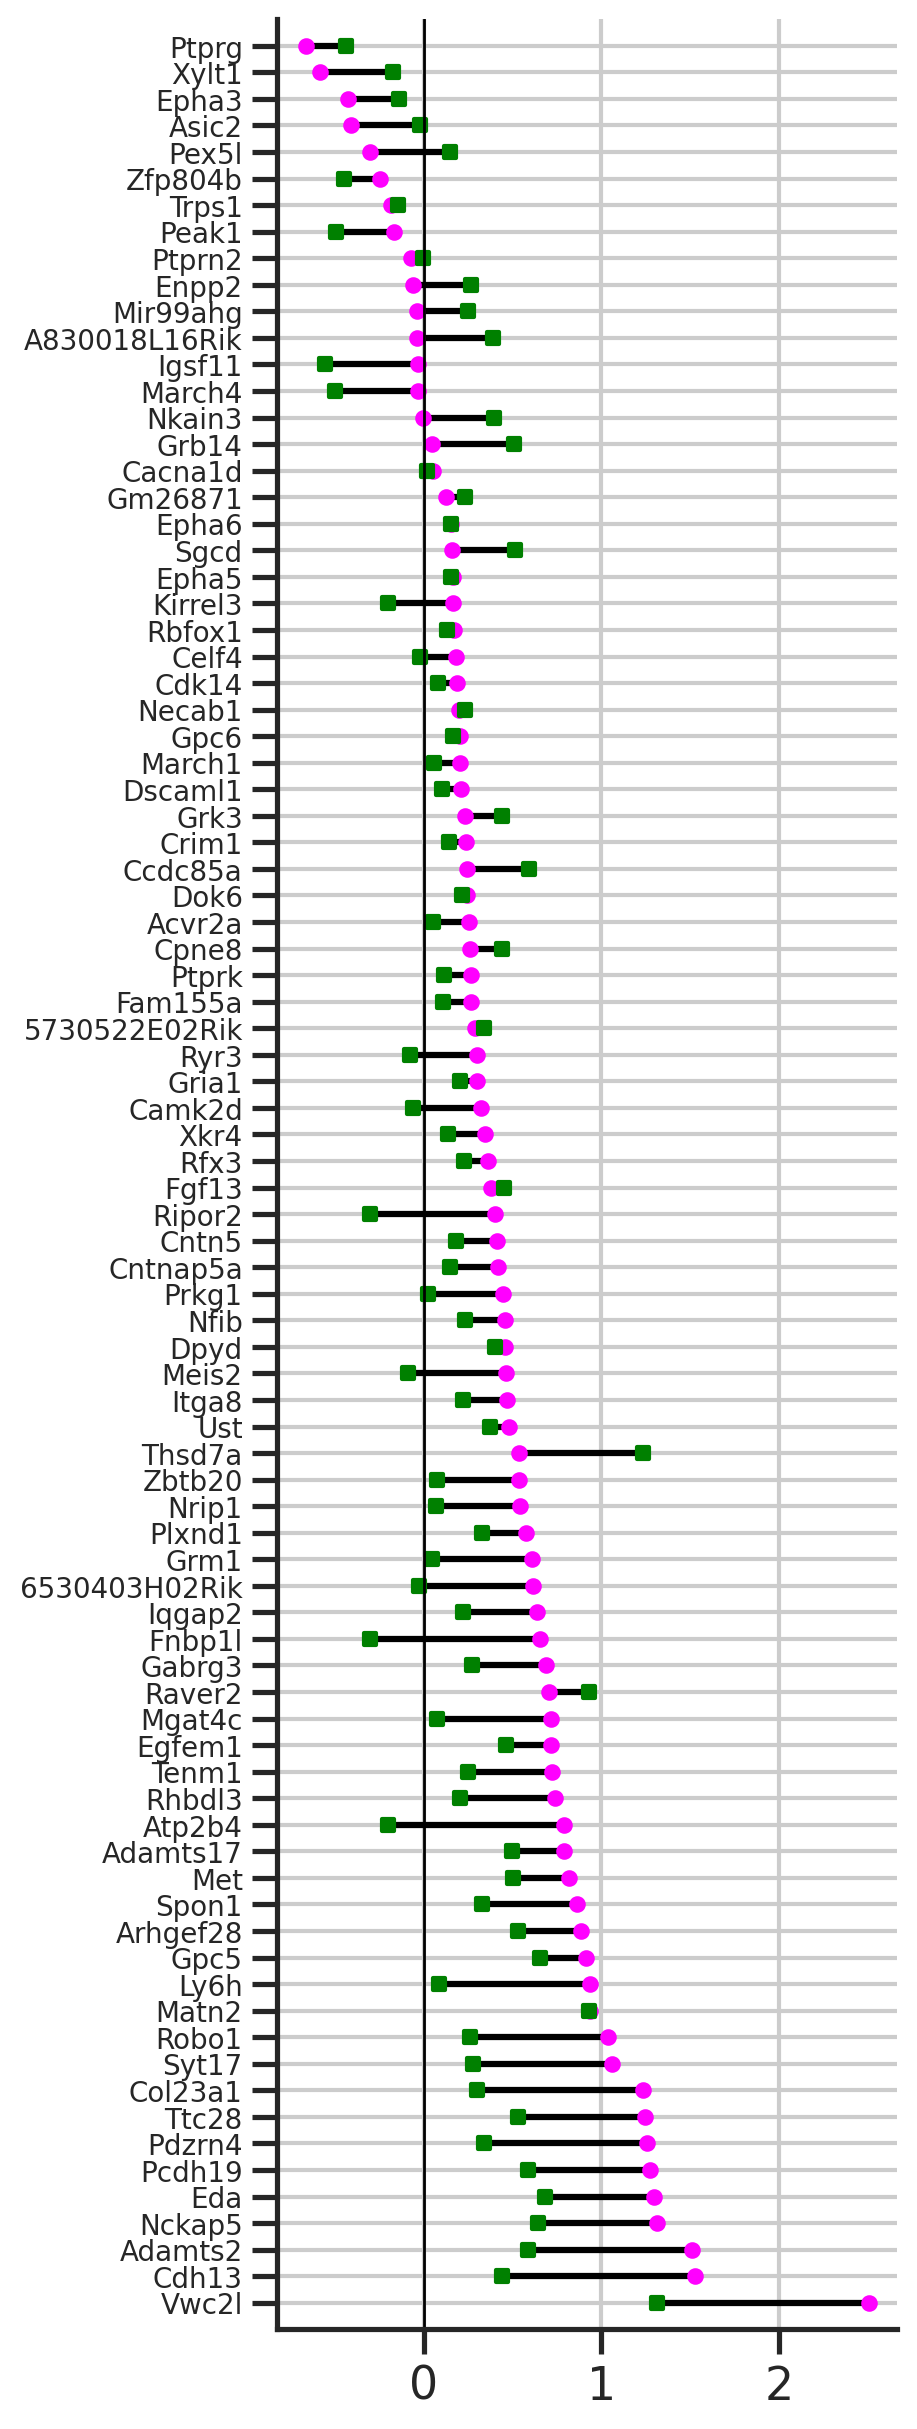

In [37]:
# combine all of them and show the changes are more in B an C
n_sub = len(cond_a)
genes_plot = genes_mul[cond_a]
del_sub = (tensor_rna[1]-tensor_rna[0])[:,cond_a]
del_sub2 = (tensor_mul[1]-tensor_mul[0])[:,cond_a]

del_sub_mean = np.mean(del_sub, axis=0)
del_sub2_mean = np.mean(del_sub2, axis=0)

support = np.arange(n_sub)
fig, ax = plt.subplots(1,1,figsize=(1*4,1*15), sharey=True)
idx = np.argsort(del_sub_mean)[::-1]

for i, isort in enumerate(idx):
    vals = np.array([del_sub_mean[isort], del_sub2_mean[isort]])
    val_min = vals[np.argmin(vals)]
    val_max = vals[np.argmax(vals)]
    ax.plot([val_min,val_max], [i,i], '-k', zorder=1)

ax.scatter(del_sub_mean[idx], support, color='magenta', s=20, )#facecolor='none') 
ax.scatter(del_sub2_mean[idx], support, color='green', s=20, marker='s', )# facecolor='none') 
    
ax.set_yticks(support)
ax.set_yticklabels(genes_plot[idx], rotation=0, fontsize=10)
ax.set_ylim([-1, n_sub])
# # ax.set_xlim([-1,1])
ax.axvline(0, color='k', linestyle='-', zorder=1, linewidth=1)
sns.despine(ax=ax)
# ax.set_ylabel(f'Archetype-enriched CSMs (n={n_subbc_csm})')
plt.show()

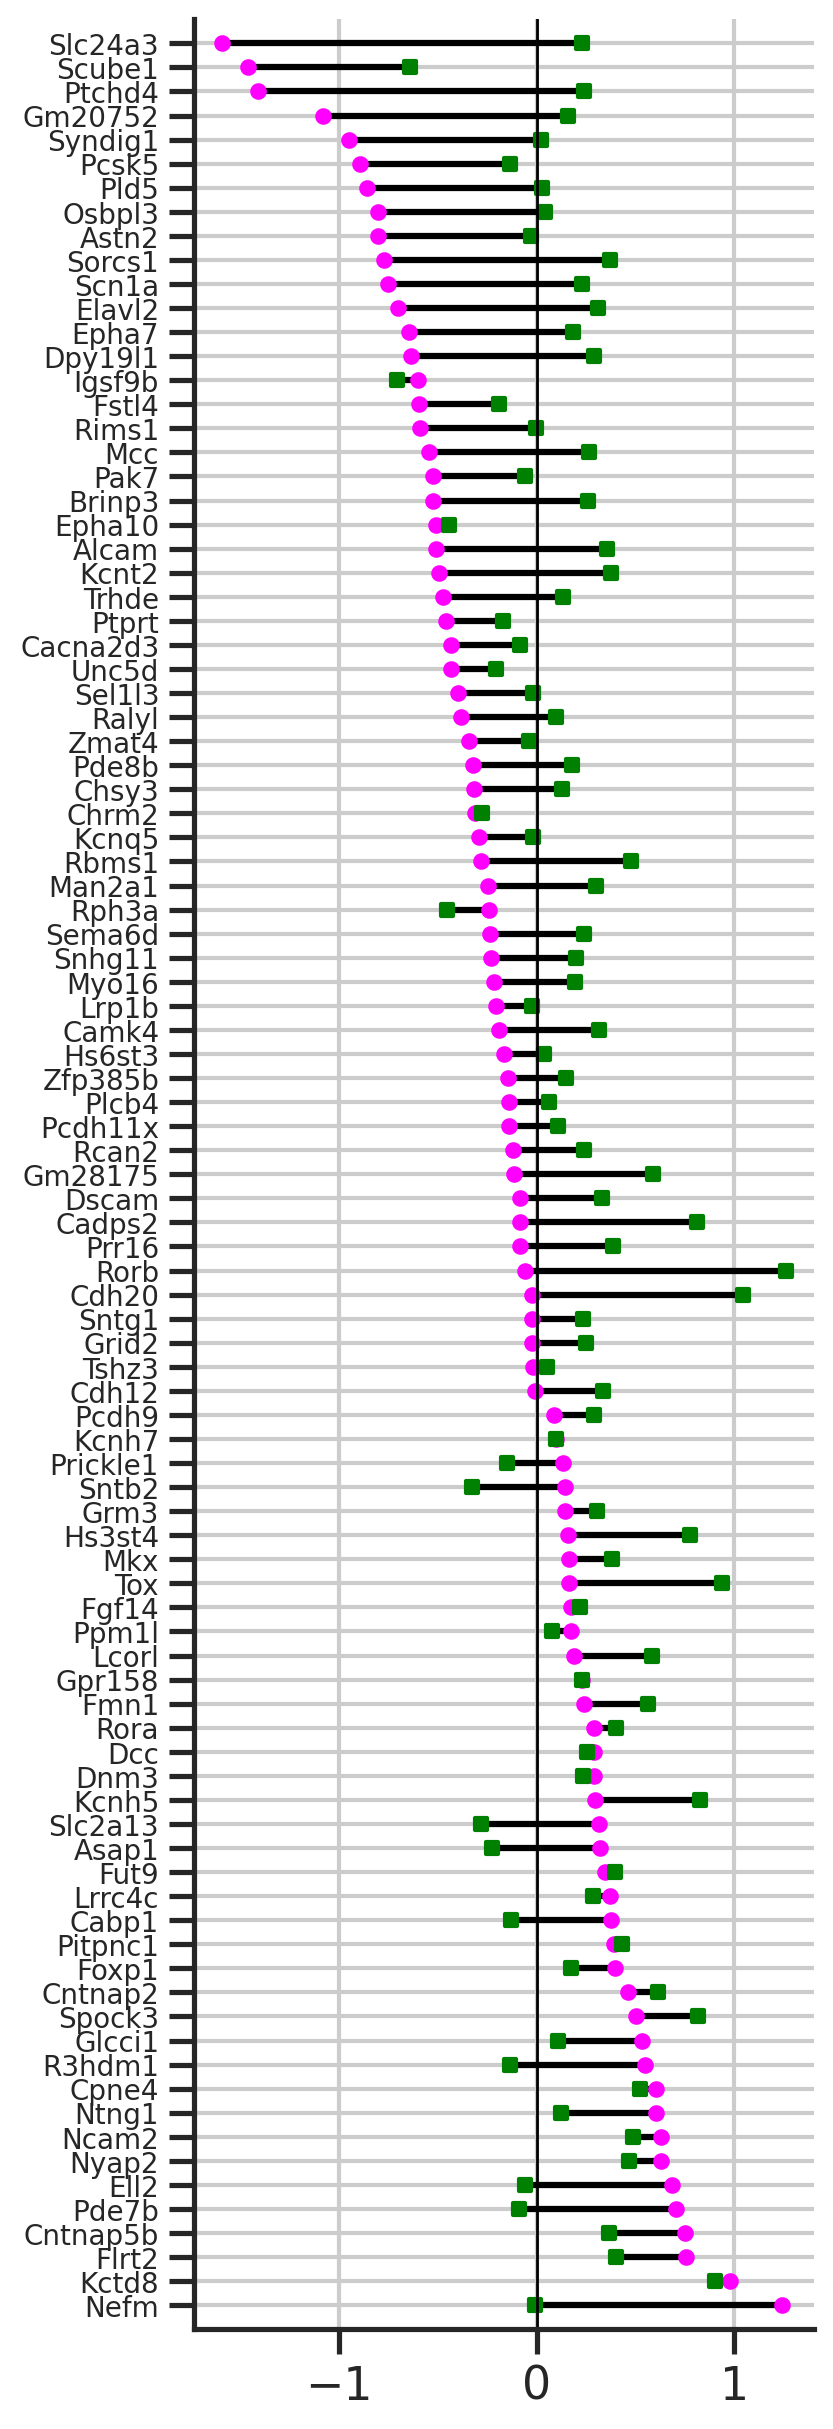

In [38]:
# combine all of them and show the changes are more in B an C
n_sub = len(cond_c)
genes_plot = genes_mul[cond_c]
del_sub = (tensor_rna[1]-tensor_rna[0])[:,cond_c]
del_sub2 = (tensor_mul[1]-tensor_mul[0])[:,cond_c]

del_sub_mean = np.mean(del_sub, axis=0)
del_sub2_mean = np.mean(del_sub2, axis=0)

support = np.arange(n_sub)
fig, ax = plt.subplots(1,1,figsize=(1*4,1*15), sharey=True)
idx = np.argsort(del_sub_mean)[::-1]

for i, isort in enumerate(idx):
    vals = np.array([del_sub_mean[isort], del_sub2_mean[isort]])
    val_min = vals[np.argmin(vals)]
    val_max = vals[np.argmax(vals)]
    ax.plot([val_min,val_max], [i,i], '-k', zorder=1)

ax.scatter(del_sub_mean[idx], support, color='magenta', s=20, )#facecolor='none') 
ax.scatter(del_sub2_mean[idx], support, color='green', s=20, marker='s', )# facecolor='none') 
    
ax.set_yticks(support)
ax.set_yticklabels(genes_plot[idx], rotation=0, fontsize=10)
ax.set_ylim([-1, n_sub])
# # ax.set_xlim([-1,1])
ax.axvline(0, color='k', linestyle='-', zorder=1, linewidth=1)
sns.despine(ax=ax)
# ax.set_ylabel(f'Archetype-enriched CSMs (n={n_subbc_csm})')
plt.show()

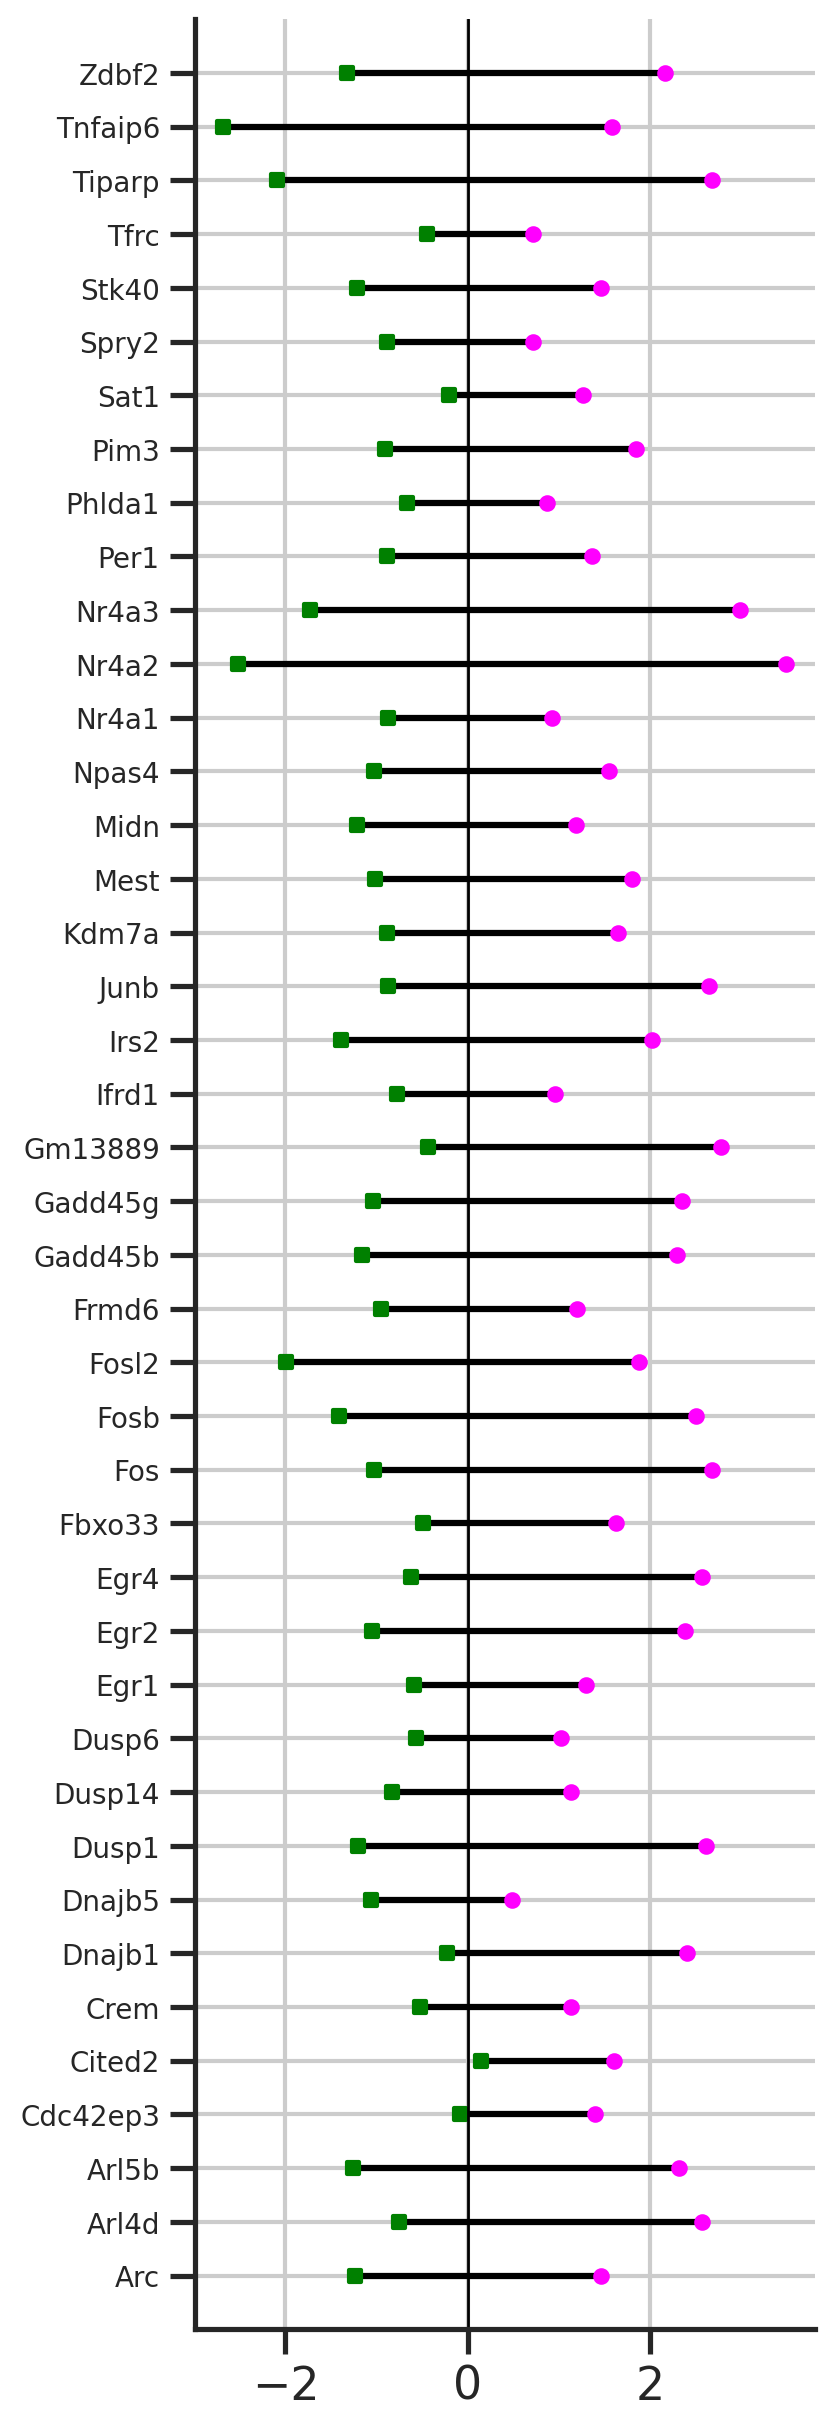

In [39]:
# combine all of them and show the changes are more in B an C
n_sub = len(cond_i)
genes_plot = genes_mul[cond_i]
del_sub = (tensor_rna[1]-tensor_rna[0])[:,cond_i]
del_sub2 = (tensor_mul[1]-tensor_mul[0])[:,cond_i]

del_sub_mean = np.mean(del_sub, axis=0)
del_sub2_mean = np.mean(del_sub2, axis=0)

support = np.arange(n_sub)
fig, ax = plt.subplots(1,1,figsize=(1*4,1*15), sharey=True)
idx = support #np.argsort(del_sub_mean)[::-1]

for i, isort in enumerate(idx):
    vals = np.array([del_sub_mean[isort], del_sub2_mean[isort]])
    val_min = vals[np.argmin(vals)]
    val_max = vals[np.argmax(vals)]
    ax.plot([val_min,val_max], [i,i], '-k', zorder=1)

ax.scatter(del_sub_mean[idx], support, color='magenta', s=20, )#facecolor='none') 
ax.scatter(del_sub2_mean[idx], support, color='green', s=20, marker='s', )# facecolor='none') 
    
ax.set_yticks(support)
ax.set_yticklabels(genes_plot[idx], rotation=0, fontsize=10)
ax.set_ylim([-1, n_sub])
# # ax.set_xlim([-1,1])
ax.axvline(0, color='k', linestyle='-', zorder=1, linewidth=1)
sns.despine(ax=ax)
# ax.set_ylabel(f'Archetype-enriched CSMs (n={n_subbc_csm})')
plt.show()

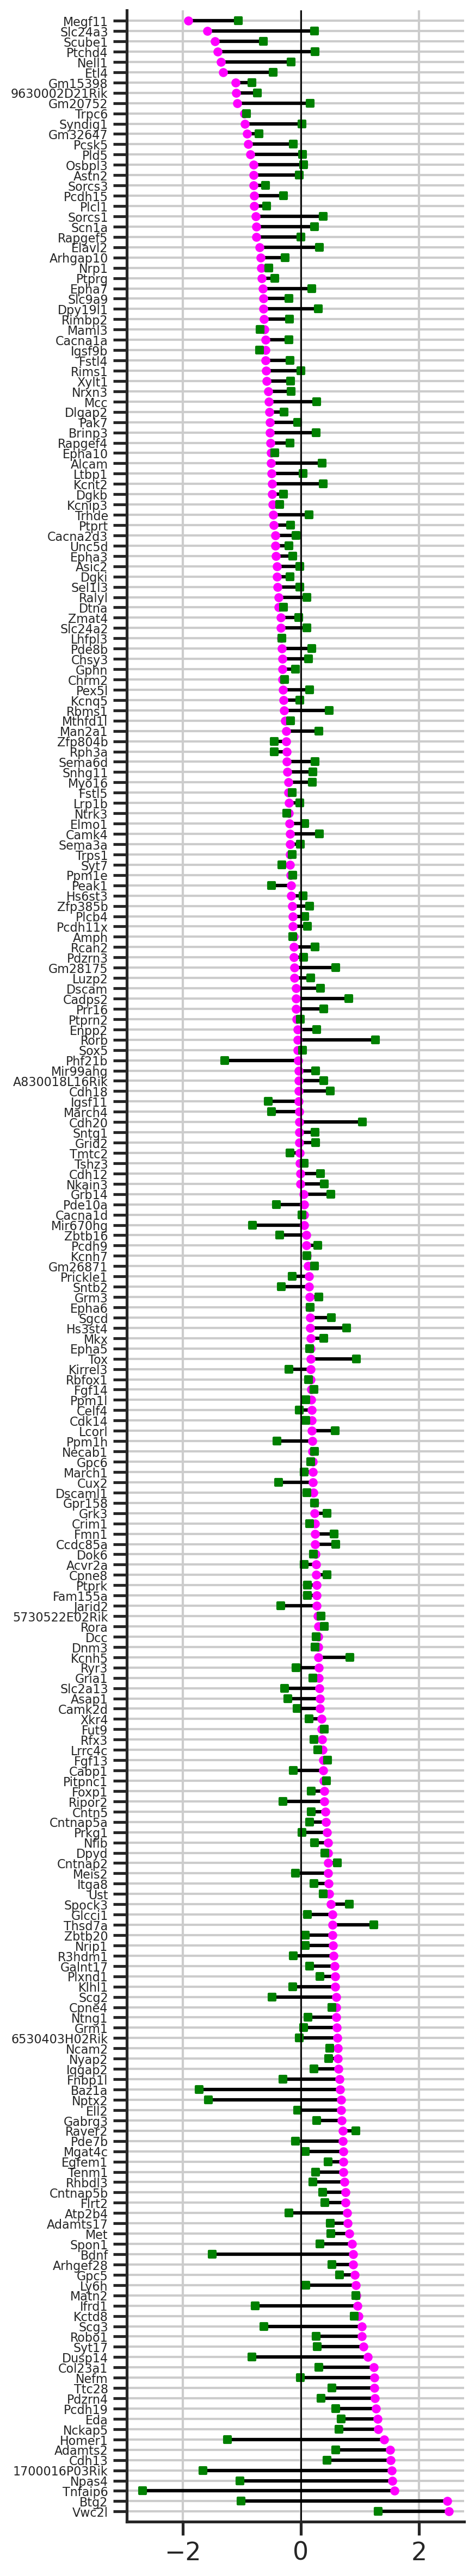

In [40]:
cond_abci = np.hstack([cond_a, cond_b, cond_c]) #, cond_i])
# combine all of them and show the changes are more in B an C
n_sub = len(cond_abci)
genes_plot = genes_mul[cond_abci]
del_sub = (tensor_rna[1]-tensor_rna[0])[:,cond_abci]
del_sub2 = (tensor_mul[1]-tensor_mul[0])[:,cond_abci]

del_sub_mean = np.mean(del_sub, axis=0)
del_sub2_mean = np.mean(del_sub2, axis=0)

support = np.arange(n_sub)
fig, ax = plt.subplots(1,1,figsize=(1*4,1*30), sharey=True)
idx = np.argsort(del_sub_mean)[::-1]

for i, isort in enumerate(idx):
    vals = np.array([del_sub_mean[isort], del_sub2_mean[isort]])
    val_min = vals[np.argmin(vals)]
    val_max = vals[np.argmax(vals)]
    ax.plot([val_min,val_max], [i,i], '-k', zorder=1)

ax.scatter(del_sub_mean[idx], support, color='magenta', s=20, )#facecolor='none') 
ax.scatter(del_sub2_mean[idx], support, color='green', s=20, marker='s', )# facecolor='none') 
    
ax.set_yticks(support)
ax.set_yticklabels(genes_plot[idx], rotation=0, fontsize=8)
ax.set_ylim([-1, n_sub])
# # ax.set_xlim([-1,1])
ax.axvline(0, color='k', linestyle='-', zorder=1, linewidth=1)
sns.despine(ax=ax)
# ax.set_ylabel(f'Archetype-enriched CSMs (n={n_subbc_csm})')
plt.show()

# narrowed plots to make a point

- how A genes change; how B genes change; how C genes change.

In [41]:
# x_fc = tensor_rna[1] - tensor_rna[0]
x_fc = tensor_rna[1] - tensor_rna[0]
y_fc = tensor_mul[1] - tensor_mul[0]

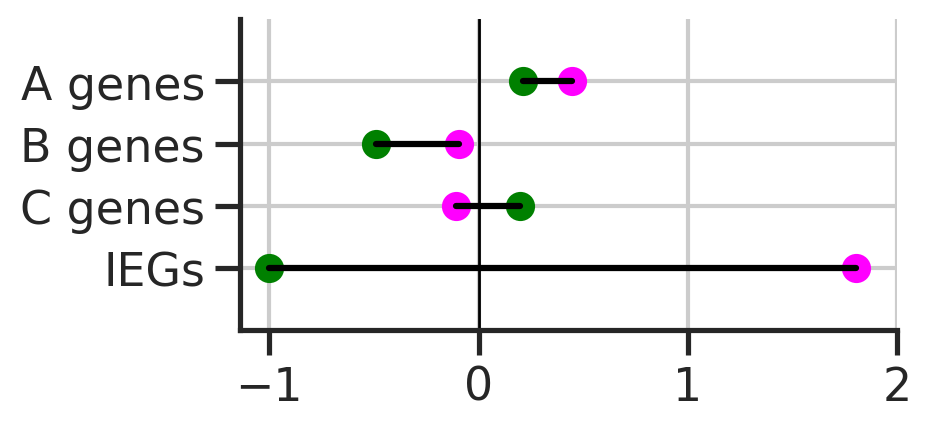

In [42]:
x_vec = [
           np.mean(x_fc[:,cond_a]),
           np.mean(x_fc[:,cond_b]),
           np.mean(x_fc[:,cond_c]),
           np.mean(x_fc[:,cond_i]),
        ] 
y_vec = [
           np.mean(y_fc[:,cond_a]),
           np.mean(y_fc[:,cond_b]),
           np.mean(y_fc[:,cond_c]),
           np.mean(y_fc[:,cond_i]),
        ] 

fig, ax = plt.subplots(1,1,figsize=(5*1,1*2.5)) #, sharey=True)
ax.scatter(x_vec, np.arange(4), color='magenta')
ax.scatter(y_vec, np.arange(4), color='green')

for i in range(4):
    vals = np.array([x_vec[i], y_vec[i]])
    val_min = vals[np.argmin(vals)]
    val_max = vals[np.argmax(vals)]
    ax.plot([val_min,val_max], [i,i], '-k', zorder=1)
    
sns.despine(ax=ax)
ax.set_yticks(np.arange(4))
ax.set_yticklabels(['A genes', 'B genes', 'C genes', 'IEGs'])
ax.set_ylim([4,-1])
ax.axvline(0, color='k', linestyle='-', zorder=1, linewidth=1)
ax.set_xticks([-1,0,1,2])

fig.tight_layout()
plt.show()


In [43]:
cond_abc = np.unique(np.hstack([
    cond_a,
    cond_b,
    cond_c,
]))


df = pd.DataFrame(np.abs(x_fc[:,cond_abc]).T, columns=['A', 'B', 'C']).unstack().reset_index()
df['label'] = 'NR'
df2 = pd.DataFrame(np.abs(y_fc[:,cond_abc]).T, columns=['A', 'B', 'C']).unstack().reset_index()
df2['label'] = 'DR'

# df = pd.concat([df, df2])
df

level_0  level_1         0 label
0         A        0  0.273317    NR
1         A        1  0.026450    NR
2         A        2  0.025909    NR
3         A        3  0.076376    NR
4         A        4  0.458824    NR
..      ...      ...       ...   ...
724       C      238  0.207570    NR
725       C      239  0.520425    NR
726       C      240  0.572344    NR
727       C      241  0.607209    NR
728       C      242  0.880106    NR

[729 rows x 4 columns]

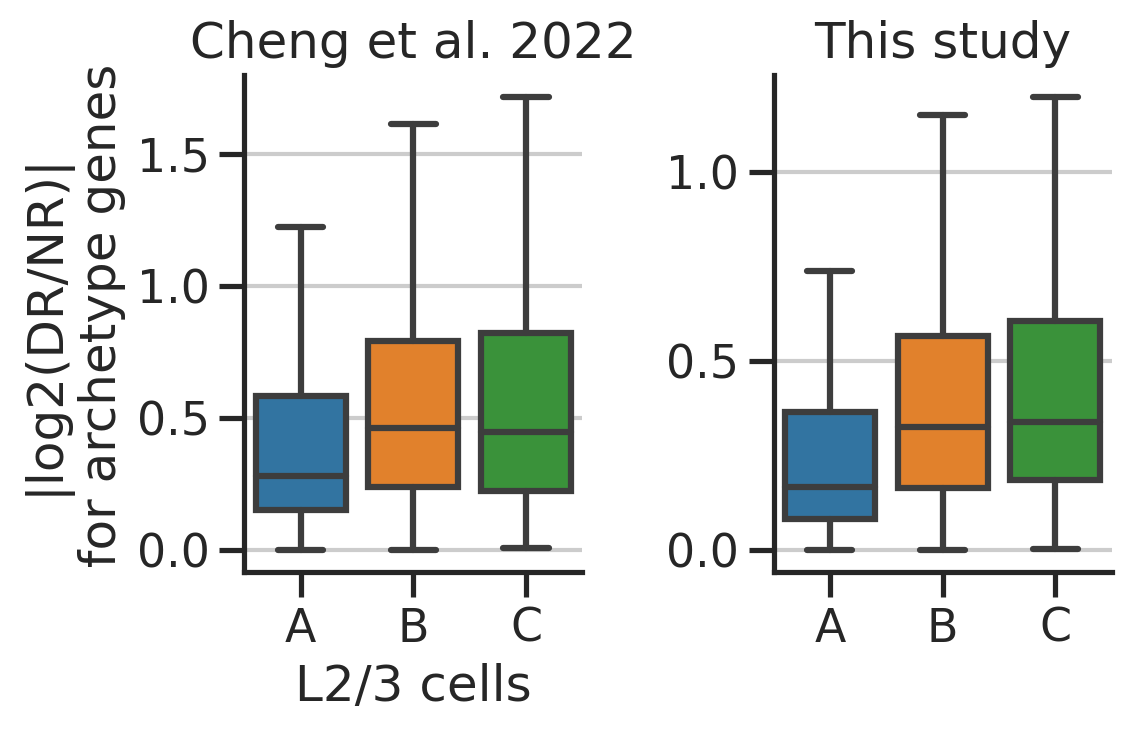

In [44]:
fig, axs = plt.subplots(1,2,figsize=(2*3,1*4))
ax = axs[0]
ax.set_title('Cheng et al. 2022')
sns.boxplot(df , x='level_0', y=0, showfliers=False, ax=ax)
# sns.violinplot(df , x='level_0', y=0, showfliers=False, ax=ax)
ax.set_ylabel('|log2(DR/NR)|\n for archetype genes')
ax.set_xlabel('L2/3 cells')
sns.despine(ax=ax)

ax = axs[1]
ax.set_title('This study')
sns.boxplot(df2, x='level_0', y=0, showfliers=False, ax=ax)
# sns.violinplot(df2, x='level_0', y=0, showfliers=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
sns.despine(ax=ax)

fig.tight_layout()
plt.show()